<a href="https://colab.research.google.com/github/Muhammad-Abdullah-Jami/UK_Bank_Stocks_Prediction/blob/main/Yfinance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installation of essential Libraries**

In [2]:
!pip install yfinance


**Importing Libraries**

In [38]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,precision_score, recall_score
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb
from sklearn.svm import SVR
from sklearn import metrics
import torch
from torch import nn
from sklearn.metrics import mean_squared_error


# **Functions**

**Orignal Dataset ploting and eda function**

In [4]:
def eda_analysis(df,ticker):
    # ploting the original dataset of stocks
    df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.set_index('Date', inplace=True)

    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df[('Close', ticker)], label='Actual Close Prices', color='blue', alpha=0.7)

    # Adding titles and labels
    plt.title("Actual Closing Prices from 2019 -2024")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accessing the 'Close' column as a tuple
    print("Close column head:\n", df[('Close', ticker)].head())
    print("Statistics for Close column:\n", df[('Close', ticker)].describe())

    #..........................................................................................
    # Distribution of Each Feature
    #..........................................................................................
    num_columns = len(df.columns)
    rows = (num_columns // 3) + (num_columns % 3 > 0)

    df.hist(bins=30, figsize=(12, 10), layout=(rows, 3))
    plt.suptitle("Distribution of Each Feature")
    plt.show()

    #..........................................................................................
    # Box Plots for Each Feature
    #..........................................................................................
    df1 = df.copy()
    df1.columns = ['_'.join(col).strip() for col in df1.columns]
    num_columns = len(df1.columns)
    rows = (num_columns // 3) + (num_columns % 3 > 0)

    df1.plot(kind='box', subplots=True, layout=(rows, 3), figsize=(12, 10), title="Box Plots for Each Feature")
    plt.tight_layout()
    plt.suptitle("Box Plots for Each Feature", y=1.02)
    plt.show()


**Feature enginreering function**

In [5]:

def feature_engineering(df, ticker):
    """

    Parameters:
        df (DataFrame): The DataFrame containing stock data with multi-level columns.
        ticker (str): The ticker symbol of the stock to use in column names.
    """
    # Example feature creation using multi-level column name
    df[('Close_diff', ticker)] = df[('Close', ticker)].diff()  # Creates a new column with differences
    df[('Close_pct_change', ticker)] = df[('Close', ticker)].pct_change()  # Percentage change

    # Example using another column
    df[('Volume_scaled', ticker)] = df[('Volume', ticker)] / 1e6  # Scale volume for easier analysis

    # If you're applying more complex transformations, ensure each uses the tuple format
    print("Feature engineering completed.")

    # Testing feature engineering code

    # Window size and alpha for moving averages
    window_size = 20  # 20-day SMA
    alpha = 0.5

    df[('CMA_Close', ticker)] = df[('Close', ticker)].expanding().mean()  # Cumulative Moving Average
    df[('SMA_Close', ticker)] = df[('Close', ticker)].rolling(window=window_size).mean()  # Simple Moving Average
    df[('EMA_Close', ticker)] = df[('Close', ticker)].ewm(alpha=alpha, min_periods=window_size).mean()  # Exponential Moving Average

    #..........................................................................................
    # Plotting Close prices along with CMA, SMA, and EMA
    #..........................................................................................
    plt.figure(figsize=(14, 8))

    plt.plot(df.index, df[('Close', ticker)], label='Close Price', color='blue', linewidth=1)
    plt.plot(df.index, df[('CMA_Close', ticker)], label='CMA (Close)', color='orange', linestyle='--')
    plt.plot(df.index, df[('SMA_Close', ticker)], label=f'SMA ({window_size}-day)', color='green', linestyle='--')
    plt.plot(df.index, df[('EMA_Close', ticker)], label=f'EMA (alpha={alpha})', color='red', linestyle='--')

    plt.title(f'{ticker} Close Price with CMA, SMA, and EMA')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# **Random Forest Regressor Function for training and evaluation with the printing of MAE, RMSE etc and ploting the future prediction**

In [43]:

def random_forest_regressor(df, X_columns, y_column, estim=100, test_size=0.2):
    """
        df (DataFrame): The DataFrame containing data.
        X_columns : List of feature column names.
        y_column : Target column name for prediction.
        estim: Number of trees in the forest.
        test_size: Test set size for train/test split.
        it also prints model performance and future predictions.
    """
    # Define features and target
    X = df[X_columns]
    y = df[y_column]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Model training
    rf_model = RandomForestRegressor(n_estimators=estim, random_state=42)
    rf_model.fit(X_train, y_train)

    # Model evaluation on test set
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rse = r2_score(y_test, y_pred)

    print("Model Performance Metrics")
    print("-" * 30)
    print(f"Mean Squared Error (MSE):       {mse:.4f}")
    print(f"Mean Absolute Error (MAE):      {mae:.4f}")
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f"Root Square Error (RSE):        {rse:.4f}")
    print("-" * 30)

    # Generate future dates for predictions
    future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=12, freq='M')
    future_data = pd.DataFrame(index=future_dates, columns=X.columns)

    # Fill future_data with dynamic values
    for col in X.columns:
        # Rolling mean or linear trend based on last few values to simulate trend
        last_value = df[col].iloc[-1]
        trend_slope = (df[col].iloc[-1] - df[col].iloc[-10]) / 10  # based on last 10 values
        future_data[col] = [last_value + trend_slope * i for i in range(1, 13)]  # increment each month

    # Predict for future dates
    future_predictions = rf_model.predict(future_data)


    # Plotting the historical and predicted data
    plt.figure(figsize=(14, 8))
    plt.plot(df.index, y, label='Historical Data', color='blue')
    plt.plot(future_dates, future_predictions, label='Predicted Data (Next Year)', color='orange', linestyle='--')
    plt.title('Stock Price Prediction for Next Year')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()


**random forset classifier to predic weather it will goes up and down with the ploting of confusion matrix**

In [41]:
def random_forest_classifier(df, X_columns, y, ticker=None):
    """
        df (DataFrame): The DataFrame containing stock data.
        X_columns : List of feature column names.
        y : The target column for prediction (up/down classification).
        ticker :  ticker name
    """
    if ticker:
        target_column = ('Close', ticker)
    else:
        target_column = 'Close'

    #making it ready for prediction
    X = df[X_columns].iloc[:-1]
    y = y.iloc[:-1]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Model training (using RandomForestClassifier)
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Model evaluation
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print("-" * 60)
    print("Model Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print("-" * 60)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Prediction for the next day (using the last day of data)
    last_day_data = X.iloc[-1].values.reshape(1, -1)
    next_day_prediction = rf_classifier.predict(last_day_data)

    if next_day_prediction == 1:
        print("The stock price is predicted to go UP.")
    else:
        print("The stock price is predicted to go DOWN.")




# **LSTM function**

In [45]:
def lstm(df, X, y, epochs, batch_size, optim, los):
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

    # Create dataset function for LSTM input
    def create_dataset(data, time_step=1):
        X, y = [], []
        for i in range(len(data) - time_step - 1):
            a = data[i:(i + time_step), 0]
            X.append(a)
            y.append(data[i + time_step, 0])
        return np.array(X), np.array(y)

    # Time step (look back period for LSTM)
    time_step = 60  # 60 days look back
    X, y = create_dataset(scaled_data, time_step)

    # Reshaping X to [samples, time steps, features] for LSTM
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Split the data into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=optim, loss=los)

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

    # Make predictions
    predicted_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)  # Rescale to original prices
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate MAE, MSE, RMSE
    mae = mean_absolute_error(y_test_rescaled, predicted_prices)
    mse = mean_squared_error(y_test_rescaled, predicted_prices)
    rmse = np.sqrt(mse)
    rse=r2_score(y_test_rescaled,predicted_prices)

    # Prepare to plot
    plt.figure(figsize=(14, 7))

    # Plot actual vs predicted prices
    plt.plot(df.index[train_size + time_step + 1:], df['Close'][train_size + time_step + 1:], label='Actual Prices', color='blue')
    plt.plot(df.index[train_size + time_step + 1:], predicted_prices, label='Predicted Prices', color='orange')

    # Adding titles and labels
    plt.title('Stock Price Prediction Using LSTM')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Make continuous predictions for the next year
    future_steps = 365  # Predicting for the next year
    last_data = scaled_data[-time_step:].reshape(1, time_step, 1)

    future_predictions = []

    for _ in range(future_steps):
        predicted_price = model.predict(last_data)
        future_predictions.append(predicted_price[0, 0])

        # Update last_data for the next prediction
        last_data = np.append(last_data[:, 1:, :], predicted_price.reshape(1, 1, 1), axis=1)

    # Prepare the index for future dates
    last_date = df.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps)

    # Create a DataFrame for future predictions
    future_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    future_df = pd.DataFrame(data=future_prices, index=future_dates, columns=['Predicted Price'])

    # Plotting future predictions
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Historical Prices', color='blue')
    plt.plot(future_df.index, future_df['Predicted Price'], label='Future Predictions', color='orange')

    # Adding titles and labels
    plt.title('Continuous Stock Price Prediction for the Next Year')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()
        # Print evaluation metrics
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f"RSE of the base model: {rse}")
    print("\n\n")


# **XGBoost Function**

In [94]:
def xgboost(df, X, y, testsiz, n_esti, learn_rate, max_dep, window_size=10, alpha=0.1):
    # Feature Engineering: Create lag features for the closing price
    data = df[['Close']].copy()
    for i in range(1, 6):  # Creating 5 lag features
        data[f'lag_{i}'] = data['Close'].shift(i)

    # Adding Technical Indicators
    ticker = 'Close'
    data[('CMA_Close', ticker)] = data['Close'].expanding().mean()
    data[('SMA_Close', ticker)] = data['Close'].rolling(window=window_size).mean()
    data[('EMA_Close', ticker)] = data['Close'].ewm(alpha=alpha, min_periods=window_size).mean()

    # Dropping missing values
    data.dropna(inplace=True)

    # Ensure X contains the lag features and technical indicators
    X = data.drop('Close', axis=1)
    y = data['Close']

    # Splitting the data into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsiz, random_state=42)

    # Initializing and fit the XGBoost model
    xg_model = xgb.XGBRegressor(objective='reg:squarederror',
                                n_estimators=n_esti,
                                learning_rate=learn_rate,
                                max_depth=max_dep)
    xg_model.fit(X_train, y_train)

    # Making predictions
    y_pred = xg_model.predict(X_test)

    #..........................................................................................
    # Plotting actual vs predicted prices
    #..........................................................................................

    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted Prices', color='orange', alpha=0.7)
    plt.title('Stock Price Prediction Using XGBoost')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Continuous prediction for the next year
    future_steps = 365
    last_data = data.iloc[-1][1:].values  # Using the lag features and indicators for prediction
    future_prices = []

    # Generate predictions for the next year
    for _ in range(future_steps):
        future_df = pd.DataFrame(data=[last_data], columns=X.columns)
        next_price = xg_model.predict(future_df)[0]
        future_prices.append(next_price)

        # Update last_data for the next iteration
        last_data = np.roll(last_data, -1)
        last_data[-1] = next_price

    # Make the future prices less bold and more noticeable
    future_prices = pd.Series(future_prices, index=pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_steps))

    # Calculate trend by diffing the predictions
    trend = future_prices.diff().dropna()

    #..........................................................................................
    # Plotting the future prediction with trend analysis
    #..........................................................................................


    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Historical Prices', color='blue', alpha=0.6)
    plt.plot(future_prices.index, future_prices, label='Future Predictions', color='orange', alpha=0.7)
    plt.fill_between(future_prices.index, future_prices, color='orange', alpha=0.2)
    plt.title('Continuous Stock Price Prediction for the Next Year Using XGBoost')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n\n")
    if trend[-1] > 0:
        print(f"Predicted trend for next year: Up")
    else:
        print(f"Predicted trend for next year: Down")

    print("\n\n")


# Standard Chartered (STAN.L)

**Data Loading and preprocessing**

In [76]:
# Fetching data for Standard Chartered (STAN.L)
ticker = "STAN.L"
data = yf.download(ticker, start="2019-01-01", end="2024-01-01")

# fixing column names by removing the ticker
df=data
# Date index in datetime formatfor graph
df.index = pd.to_datetime(df.index)
df.head()

[*********************100%***********************]  1 of 1 completed


Price                       Adj Close       Close        High         Low  \
Ticker                         STAN.L      STAN.L      STAN.L      STAN.L   
Date                                                                        
2019-01-02 00:00:00+00:00  501.606201  606.400024  607.700012  584.099976   
2019-01-03 00:00:00+00:00  485.310638  586.700012  610.799988  582.700012   
2019-01-04 00:00:00+00:00  502.764252  607.799988  611.200012  596.000000   
2019-01-07 00:00:00+00:00  491.845337  594.599976  609.599976  590.900024   
2019-01-08 00:00:00+00:00  507.065582  613.000000  623.500000  593.599976   

Price                            Open   Volume  
Ticker                         STAN.L   STAN.L  
Date                                            
2019-01-02 00:00:00+00:00  596.000000  4442051  
2019-01-03 00:00:00+00:00  596.599976  7359146  
2019-01-04 00:00:00+00:00  597.400024  7283237  
2019-01-07 00:00:00+00:00  606.900024  7184535  
2019-01-08 00:00:00+00:00  596.799988  7575939

In [77]:
print(df.columns)
print(data.columns)

MultiIndex([('Adj Close', 'STAN.L'),
            (    'Close', 'STAN.L'),
            (     'High', 'STAN.L'),
            (      'Low', 'STAN.L'),
            (     'Open', 'STAN.L'),
            (   'Volume', 'STAN.L')],
           names=['Price', 'Ticker'])
MultiIndex([('Adj Close', 'STAN.L'),
            (    'Close', 'STAN.L'),
            (     'High', 'STAN.L'),
            (      'Low', 'STAN.L'),
            (     'Open', 'STAN.L'),
            (   'Volume', 'STAN.L')],
           names=['Price', 'Ticker'])


In [78]:
print("-" * 60)
print("info")
print("-" * 60)
print(df.info())
print("-" * 60)
print("Describe")
print("-" * 60)
print(df.describe())
print("-" * 60)
print("isnull")
print("-" * 60)
print(df.isnull().sum())


------------------------------------------------------------
info
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1261 entries, 2019-01-02 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (Adj Close, STAN.L)  1261 non-null   float64
 1   (Close, STAN.L)      1261 non-null   float64
 2   (High, STAN.L)       1261 non-null   float64
 3   (Low, STAN.L)        1261 non-null   float64
 4   (Open, STAN.L)       1261 non-null   float64
 5   (Volume, STAN.L)     1261 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 69.0 KB
None
------------------------------------------------------------
Describe
------------------------------------------------------------
Price     Adj Close        Close         High          Low         Open  \
Ticker       STAN.L       STAN.L       STAN.L       STAN.

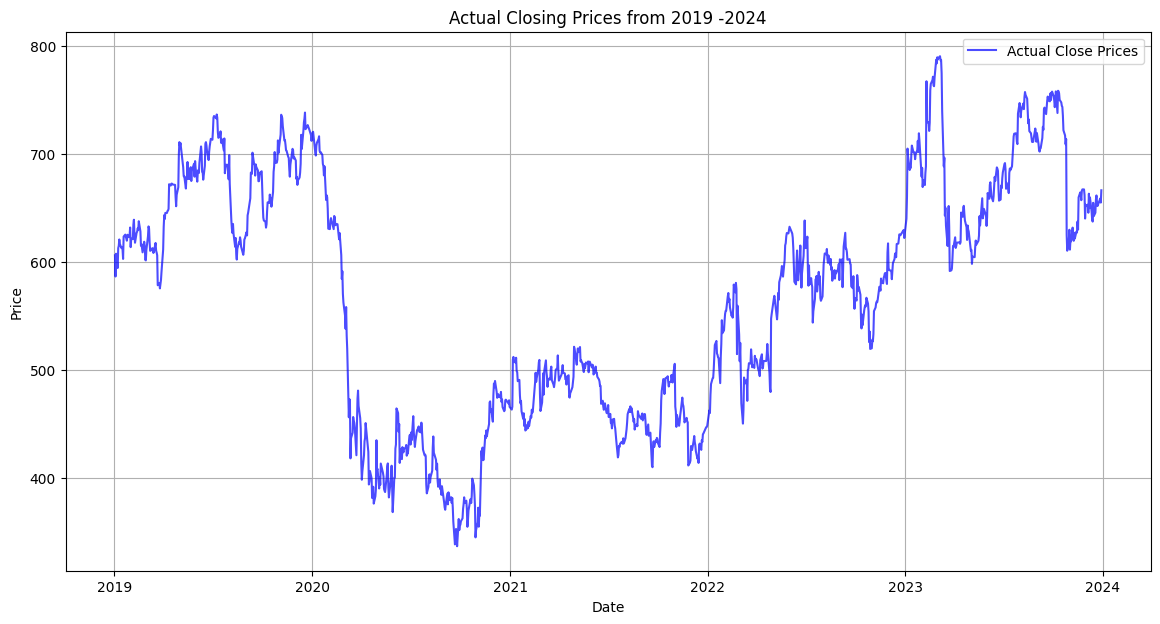

Close column head:
 Date
2019-01-02 00:00:00+00:00    606.400024
2019-01-03 00:00:00+00:00    586.700012
2019-01-04 00:00:00+00:00    607.799988
2019-01-07 00:00:00+00:00    594.599976
2019-01-08 00:00:00+00:00    613.000000
Name: (Close, STAN.L), dtype: float64
Statistics for Close column:
 count    1261.000000
mean      567.990634
std       111.144439
min       336.799988
25%       466.100006
50%       585.599976
75%       661.000000
max       790.799988
Name: (Close, STAN.L), dtype: float64


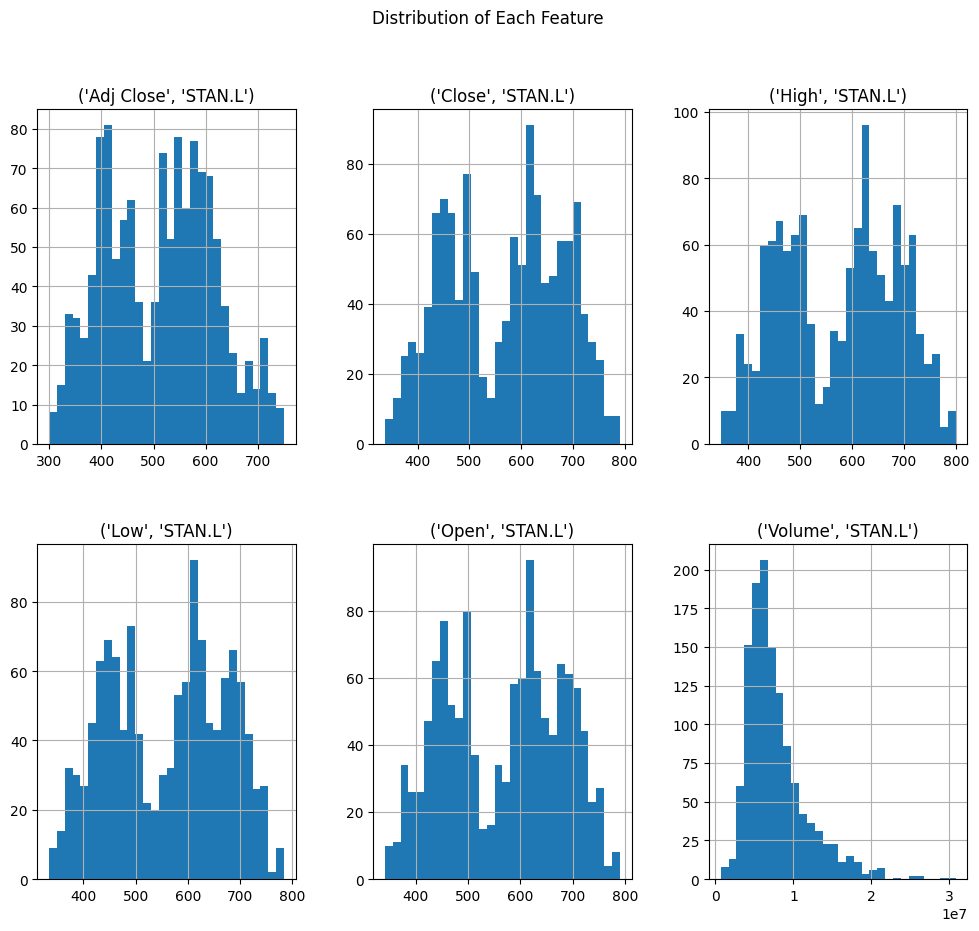

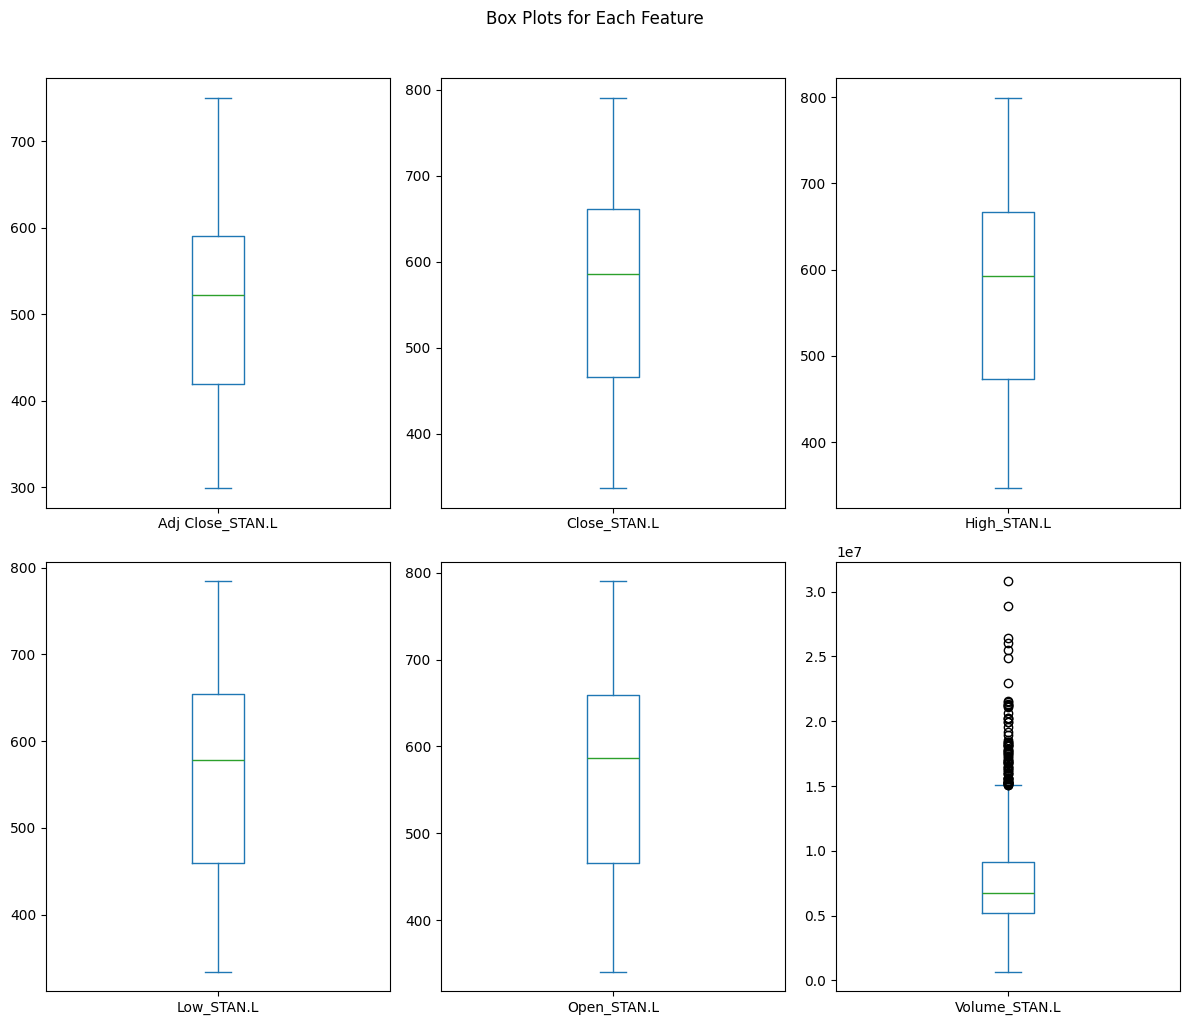

In [79]:
eda_analysis(df,ticker)

Feature engineering completed.


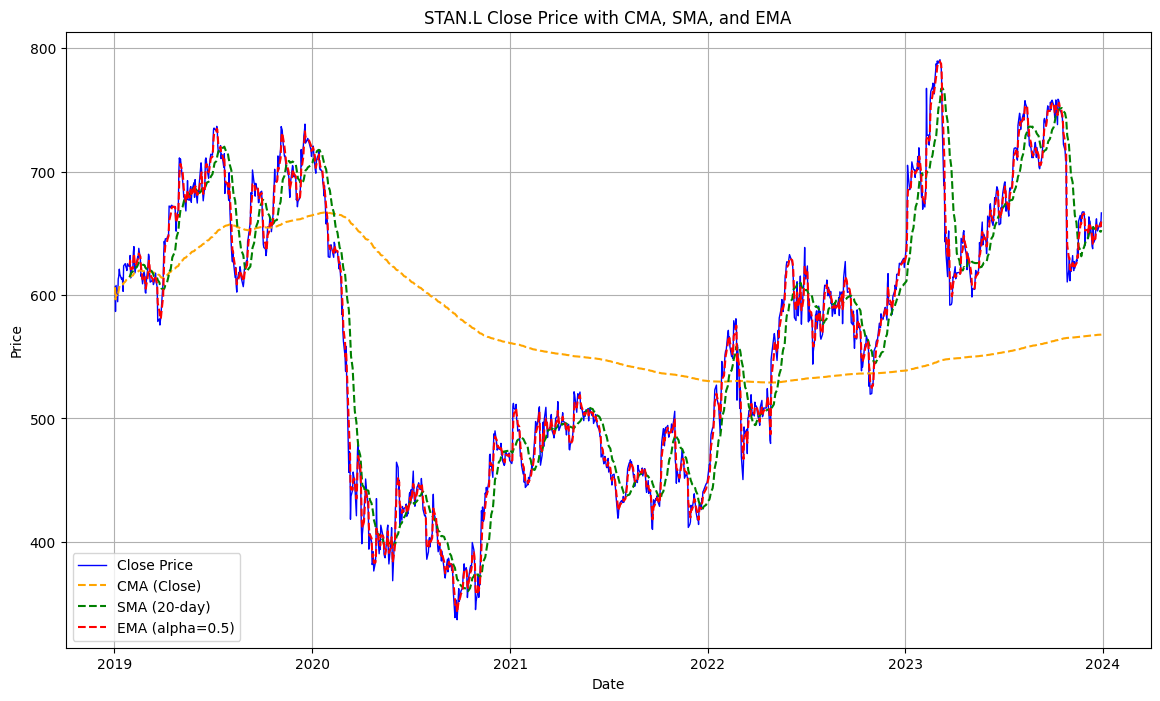

In [80]:
#data = yf.download(ticker, start="2019-01-01", end="2024-01-01", auto_adjust=True)
feature_engineering(data,ticker)

**Random forest**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model Performance Metrics
------------------------------
Mean Squared Error (MSE):       56.6155
Mean Absolute Error (MAE):      5.1919
Root Mean Squared Error (RMSE): 7.5243246405893185
Root Square Error (RSE):        0.9953
------------------------------


<ipython-input-43-6ddfd697081f>:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=12, freq='M')


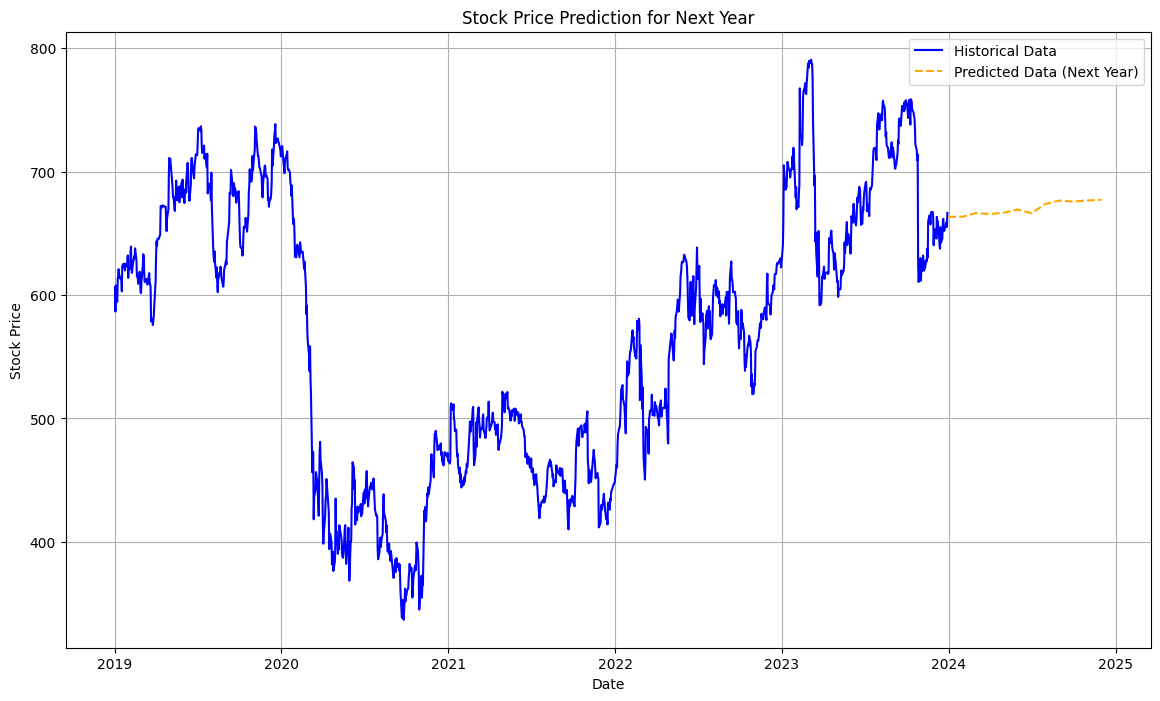

In [44]:
X_columns = ['CMA_Close', 'SMA_Close', 'EMA_Close']
y_column = 'Close'
random_forest_regressor(df, X_columns, y_column, estim=100, test_size=0.2)

**Using random forest classifier to just predict weather it goes up ir down**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


------------------------------------------------------------
Model Evaluation Metrics:
Accuracy: 0.54
F1 Score: 0.54
Precision: 0.51
Recall: 0.57
------------------------------------------------------------


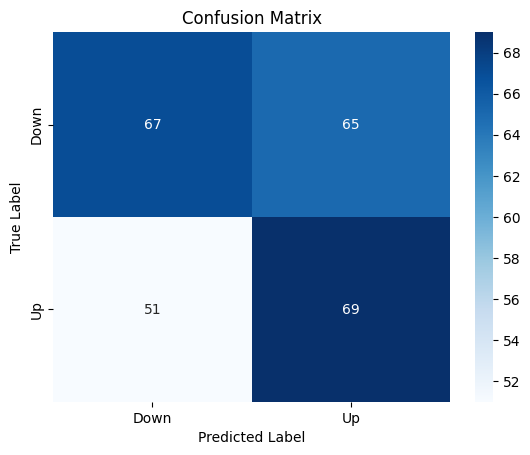

The stock price is predicted to go UP.


In [42]:
X_columns = ['CMA_Close', 'SMA_Close', 'EMA_Close']
y = (df['Close'].shift(-1) > df['Close']).astype(int)
random_forest_classifier(df, X_columns, y, ticker)

## LSTM

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0882
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0087
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0056
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0050
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0055
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0047
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0042
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0045
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0038
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0037
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0039
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0040
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0038
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0036
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0039
Epoch 16/50
30/

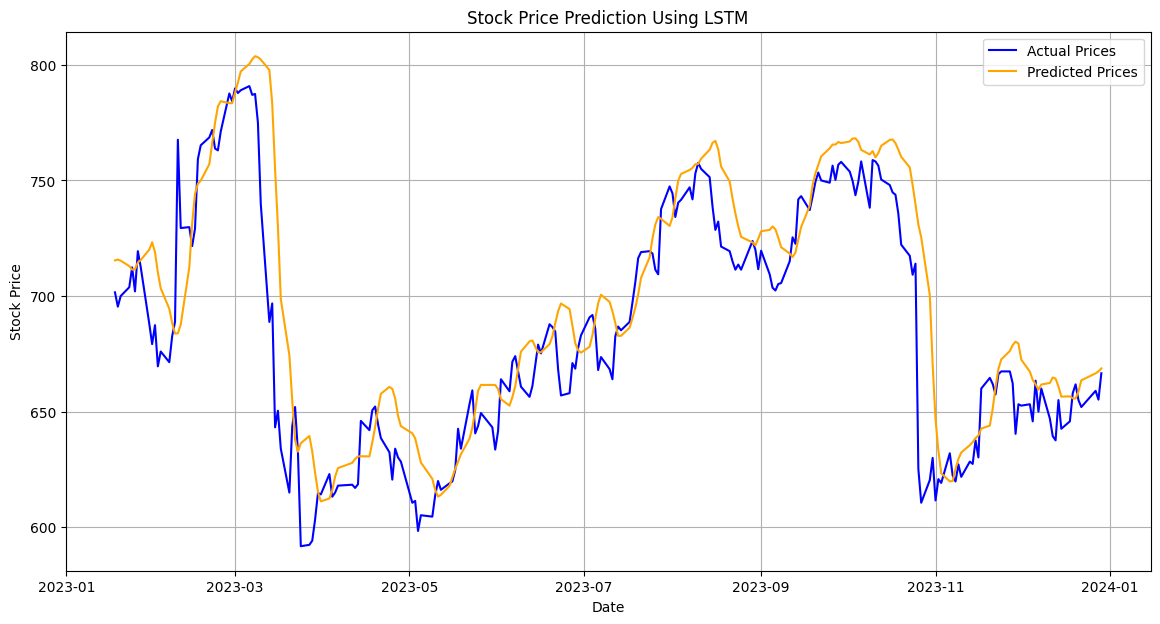

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

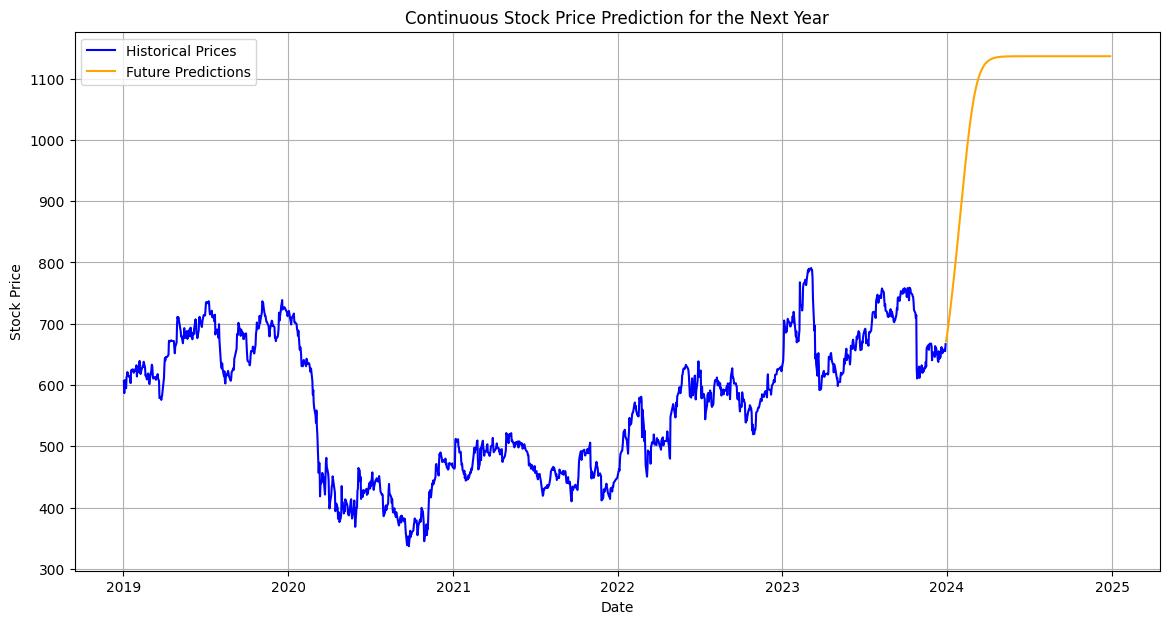

Mean Absolute Error (MAE): 15.651366170247396
Mean Squared Error (MSE): 480.66619199672715
Root Mean Squared Error (RMSE): 21.92410071124303
RSE of the base model: 0.8178125306350799





In [46]:
X_columns = ['CMA_Close', 'SMA_Close', 'EMA_Close']  # put actual  column names of teh dataset
y_column = 'Close'
lstm(df, X_columns, y_column, epochs=50, batch_size=32, optim='adam', los='mean_squared_error')


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.1138
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0099
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0057
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0054
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0050
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0042
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0043
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0040
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0039
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0040
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0041
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0037
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0044
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0038
Epoch 15/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0034


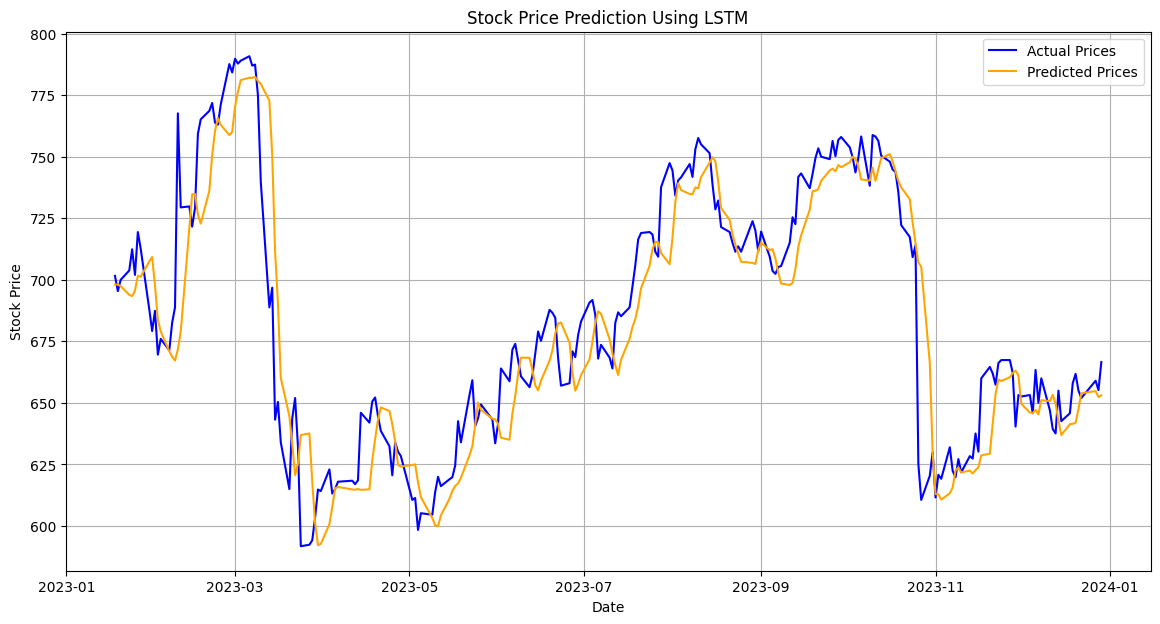

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

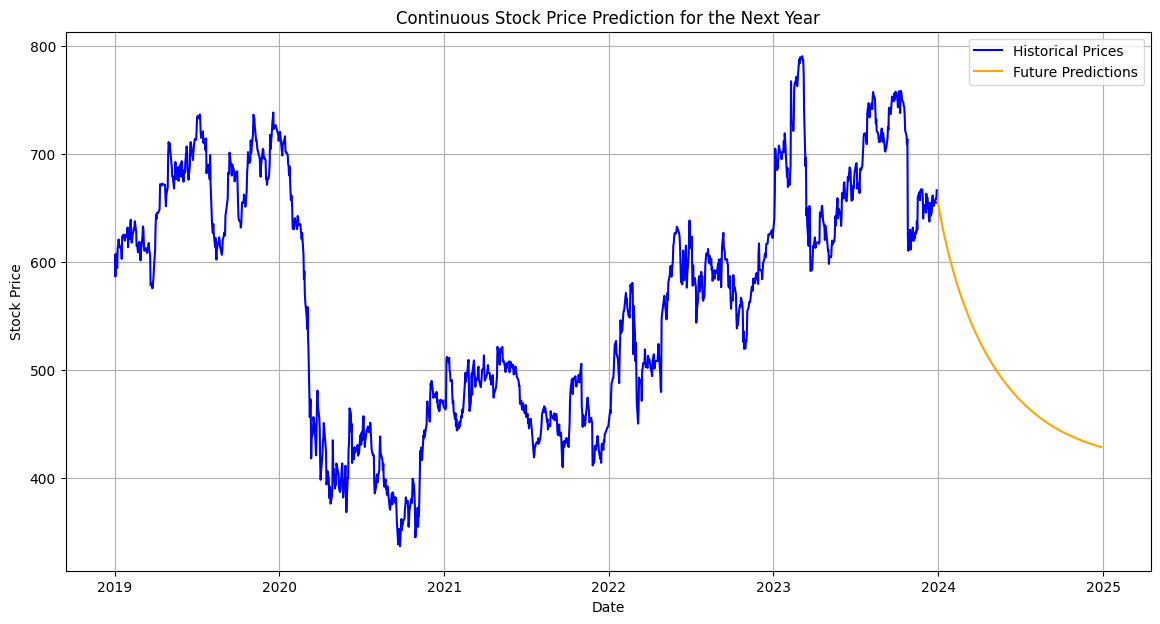

Mean Absolute Error (MAE): 11.023480987548828
Mean Squared Error (MSE): 253.0740948836164
Root Mean Squared Error (RMSE): 15.908302702790653
RSE of the base model: 0.9040770295969189





In [47]:
X_columns = ['CMA_Close', 'SMA_Close', 'EMA_Close']  # put actual  column names of teh dataset
y_column = 'Close'
lstm(df, X_columns, y_column, epochs=100, batch_size=40, optim='adam', los='mean_squared_error')


## XGBoost

In [97]:
df['Close'] = df['Close'].astype(float)
X = df.drop('Close', axis=1)
y = df['Close']





<ipython-input-94-9d4aa7df0f0c>:17: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = data.drop('Close', axis=1)


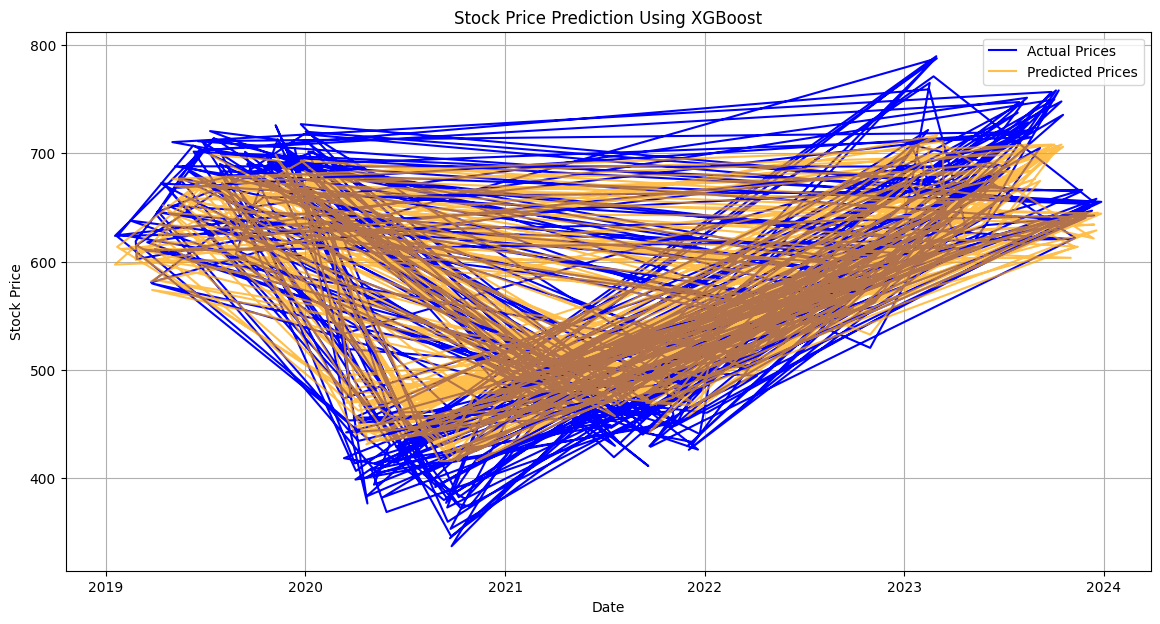

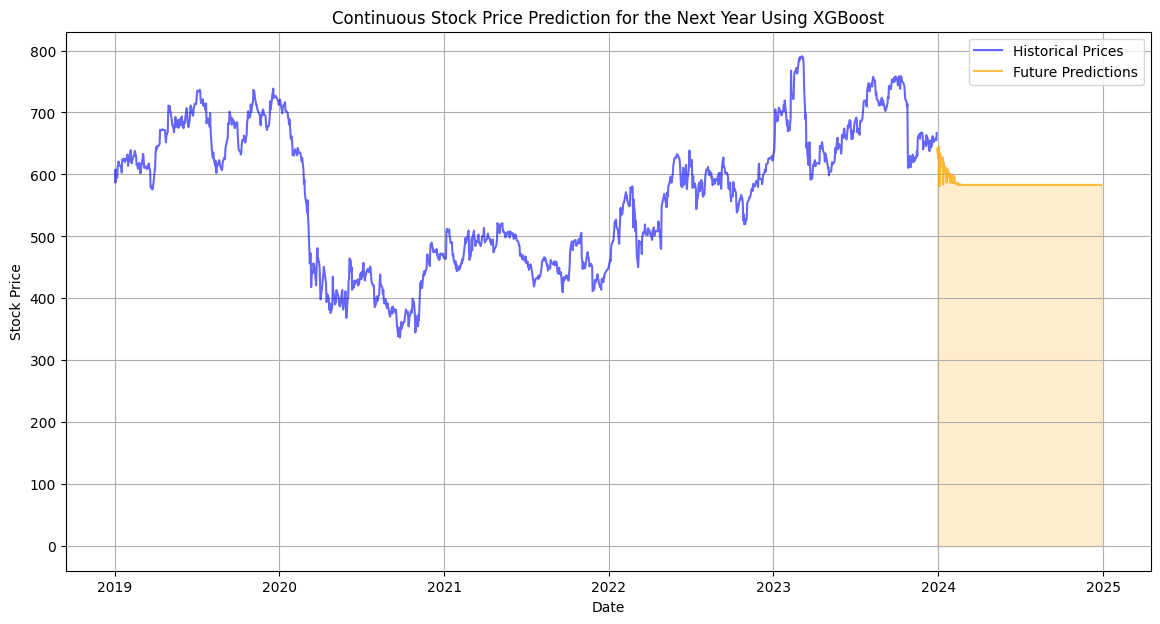




Predicted trend for next year: Down





<ipython-input-94-9d4aa7df0f0c>:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if trend[-1] > 0:


In [96]:
xgboost(df, X, y, testsiz=0.3, n_esti=150, learn_rate=0.01, max_dep=5)


**Experiment with hyperparameters**

<ipython-input-94-9d4aa7df0f0c>:17: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = data.drop('Close', axis=1)


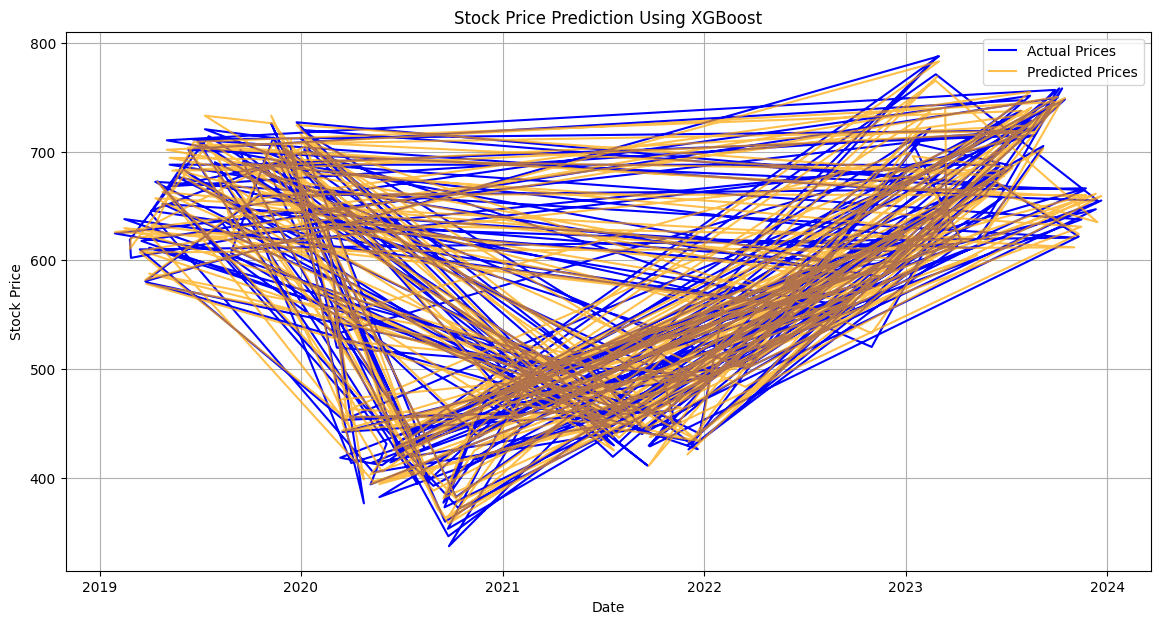

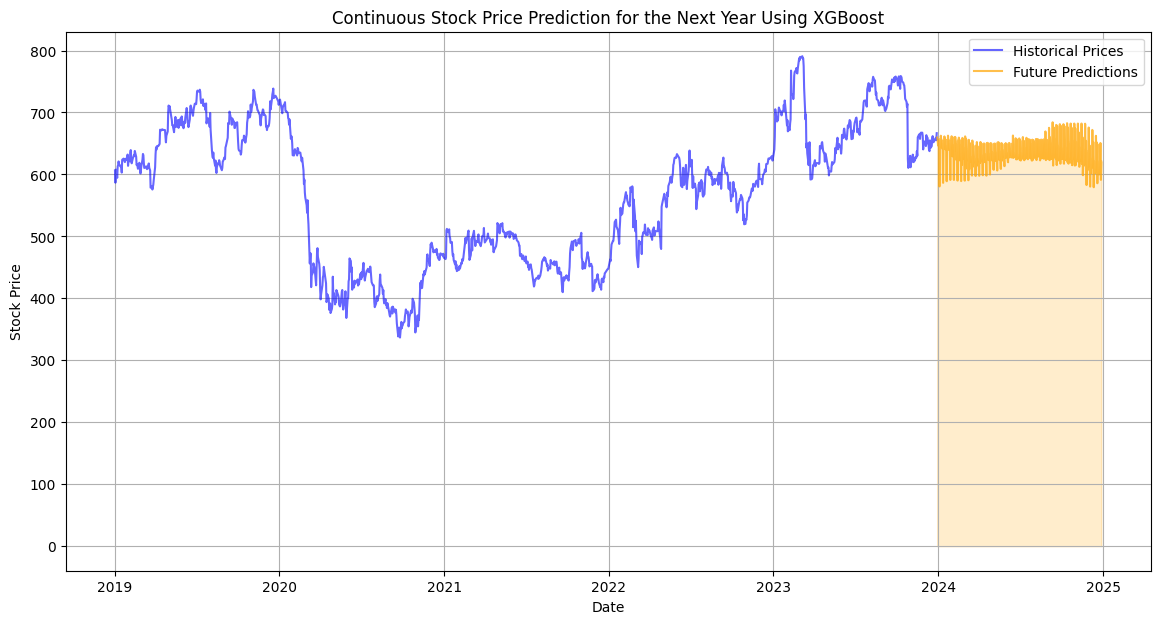




Predicted trend for next year: Up





<ipython-input-94-9d4aa7df0f0c>:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if trend[-1] > 0:


In [98]:
xgboost(df, X, y, testsiz=0.2, n_esti=100, learn_rate=0.1, max_dep=5)

## SVM

In [ ]:

data = df[['Close']].copy()

# Feature Engineering: Create lag features for the closing price
for i in range(1, 6):  # Creating 5 lag features
    data[f'lag_{i}'] = data['Close'].shift(i)

# Dropping missing values
data.dropna(inplace=True)

# Splitting the data into features (X) and target (y)
X = data.drop('Close', axis=1)
y = data['Close']

# Splitting the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the SVM model
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [ ]:
y_pred = svm_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("\n\n")
print("-" * 30)
print(f'MSE: {mse:.2f}')
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse:.2f}')
print("-" * 30)
print("\n\n")




------------------------------
MSE: 901.31
RMSE: 30.02
------------------------------





/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


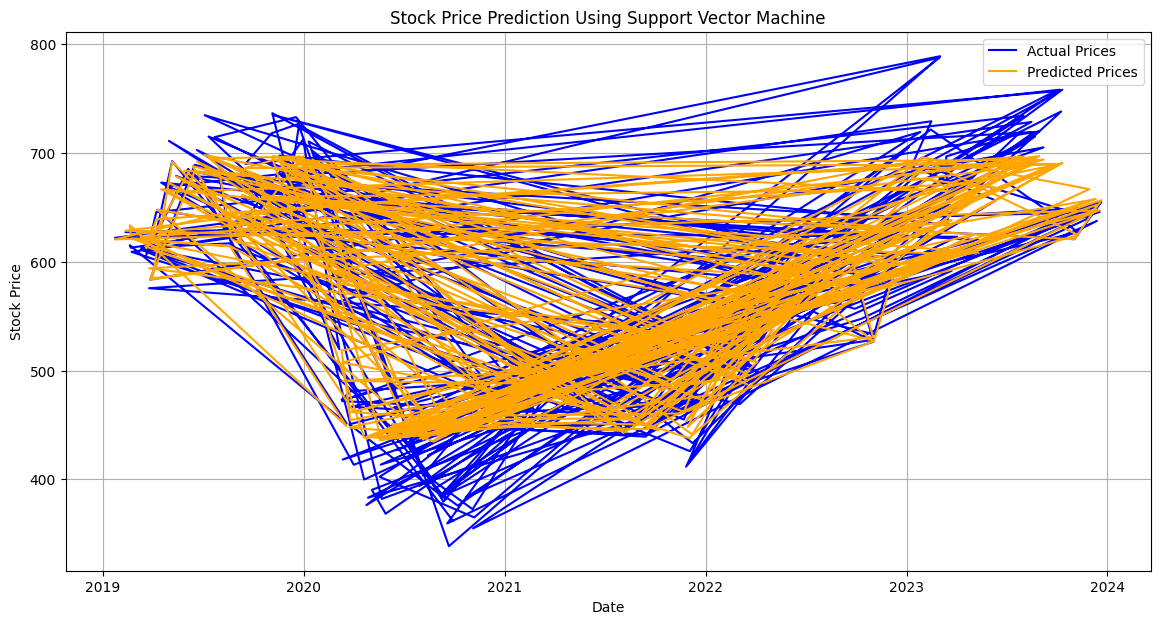

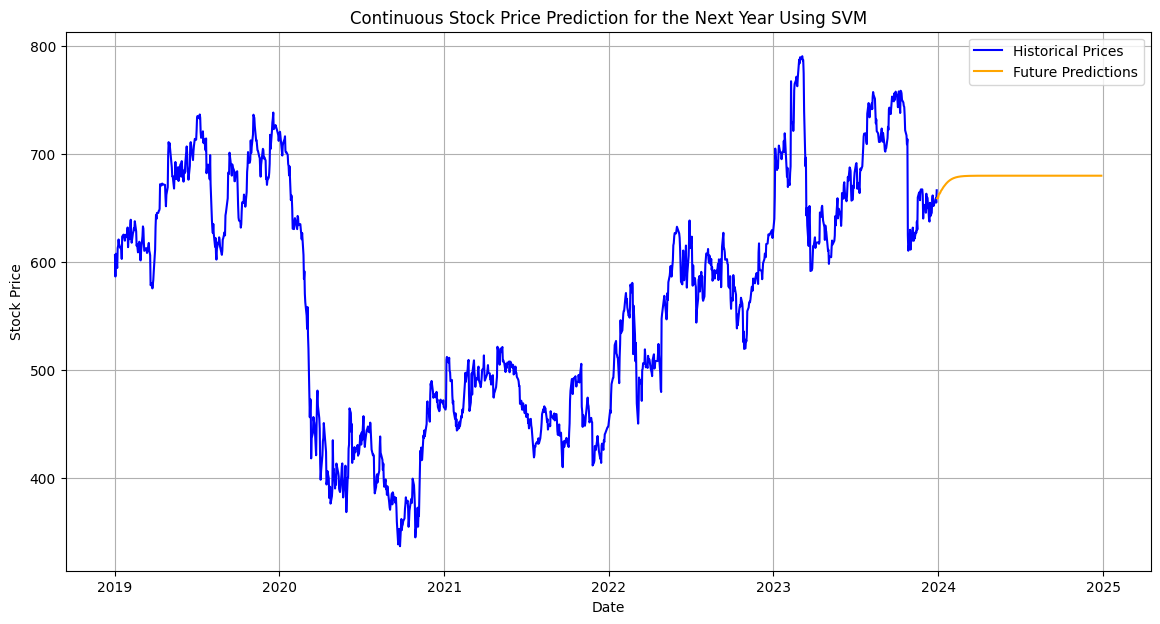

In [ ]:

y_pred = svm_model.predict(X_test)

# Plotting actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Prices', color='orange')

# Adding titles and labels
plt.title('Stock Price Prediction Using Support Vector Machine')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Continuous prediction for the next year
# Preparing to create future data for predictions
future_steps = 365

# Creating an array to hold the last observed data points with lag features
last_data = data.iloc[-1][1:].values  # Get the last row of lag features (excluding 'Close')

# Initialize an empty list to store future predictions
future_prices = []

# Generate predictions for the next year
for _ in range(future_steps):
    # Creating a DataFrame for the next prediction with the correct number of lag features
    future_df = pd.DataFrame(data=[last_data], columns=X.columns)

    # Predict the next price
    next_price = svm_model.predict(future_df)[0]
    future_prices.append(next_price)

    # Update last_data for the next iteration
    last_data = np.roll(last_data, -1)  # Shift the lag features to the left
    last_data[-1] = next_price  # Add the predicted price as the last lag feature

# Prepare the index for future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps)

# Create a DataFrame for future predictions
future_df = pd.DataFrame(data=future_prices, index=future_dates, columns=['Predicted Price'])

# Plotting historical and future predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Historical Prices', color='blue')
plt.plot(future_df.index, future_df['Predicted Price'], label='Future Predictions', color='orange')

# Adding titles and labels
plt.title('Continuous Stock Price Prediction for the Next Year Using SVM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


**Experiment with hyperparameters**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


C = 1.0
epsilon = 0.01
kernel = 'rbf'

svm_model = SVR(kernel=kernel, C=C, epsilon=epsilon)
svm_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(epsilon=0.01)

In [ ]:
y_pred = svm_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("\n\n")
print("-" * 30)
print(f'MSE: {mse:.2f}')
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse:.2f}')
print("-" * 30)
print("\n\n")




------------------------------
MSE: 971.61
RMSE: 31.17
------------------------------





/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


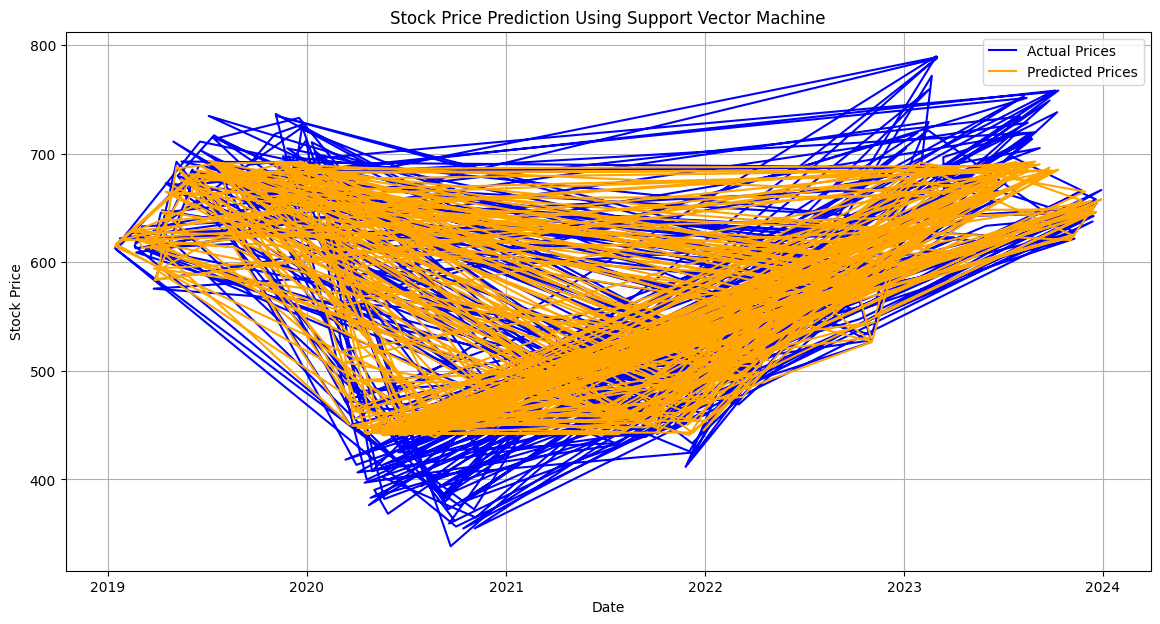

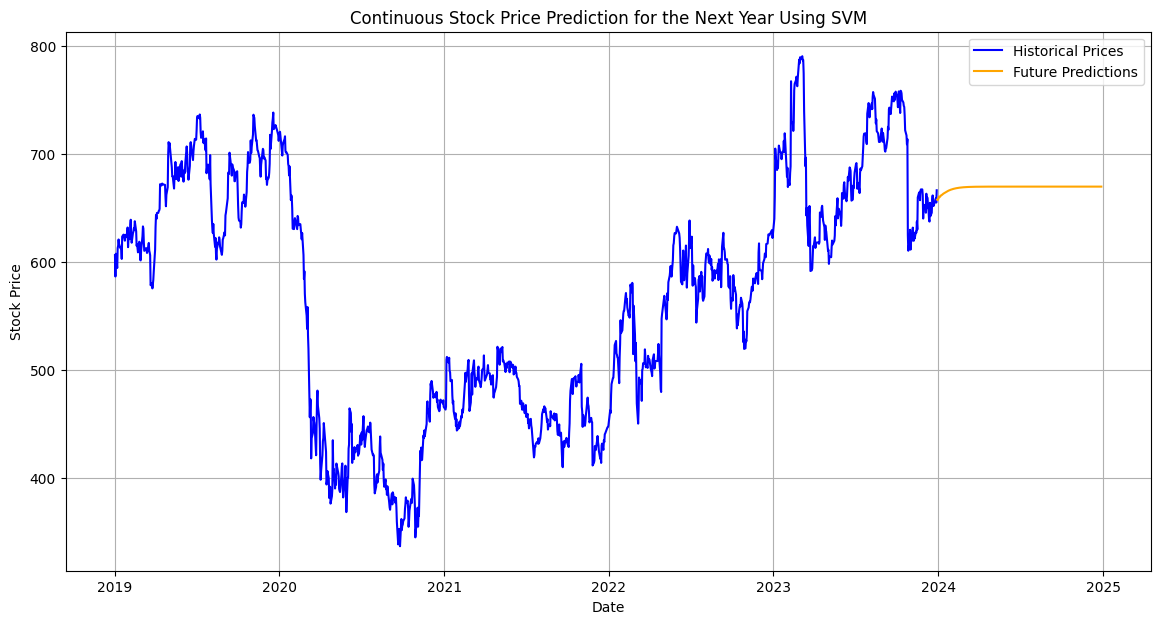

In [ ]:

y_pred = svm_model.predict(X_test)

# Plotting actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Prices', color='orange')

# Adding titles and labels
plt.title('Stock Price Prediction Using Support Vector Machine')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Continuous prediction for the next year
# Preparing to create future data for predictions
future_steps = 365

# Creating an array to hold the last observed data points with lag features
last_data = data.iloc[-1][1:].values  # Get the last row of lag features (excluding 'Close')

# Initialize an empty list to store future predictions
future_prices = []

# Generate predictions for the next year
for _ in range(future_steps):
    # Creating a DataFrame for the next prediction with the correct number of lag features
    future_df = pd.DataFrame(data=[last_data], columns=X.columns)

    # Predict the next price
    next_price = svm_model.predict(future_df)[0]
    future_prices.append(next_price)

    # Update last_data for the next iteration
    last_data = np.roll(last_data, -1)  # Shift the lag features to the left
    last_data[-1] = next_price  # Add the predicted price as the last lag feature

# Prepare the index for future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps)

# Create a DataFrame for future predictions
future_df = pd.DataFrame(data=future_prices, index=future_dates, columns=['Predicted Price'])

# Plotting historical and future predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Historical Prices', color='blue')
plt.plot(future_df.index, future_df['Predicted Price'], label='Future Predictions', color='orange')

# Adding titles and labels
plt.title('Continuous Stock Price Prediction for the Next Year Using SVM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


## Timeseries Transformer

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])

# Creating sequences for training
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return torch.FloatTensor(np.array(sequences)), torch.FloatTensor(np.array(labels))  # Convert lists to arrays first

# Set the sequence length
seq_length = 20  # 20 days of closing prices to predict the next day

# Create sequences
X_seq, y_seq = create_sequences(scaled_data, seq_length)

# Split into train and test sets
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]



# **Barclays  BARC.L**

In [ ]:
# Fetching data for Barclays  (BARC.L)
ticker = "BARC.L"
data = yf.download(ticker, start="2019-01-01", end="2024-01-01")

# fixing column names by removing the ticker
df=data
# Date index in datetime formatfor graph
df.index = pd.to_datetime(df.index)
df.head()





[*********************100%***********************]  1 of 1 completed


Price                       Adj Close       Close        High         Low  \
Ticker                         BARC.L      BARC.L      BARC.L      BARC.L   
Date                                                                        
2019-01-02 00:00:00+00:00  124.531792  150.679993  151.199997  145.440002   
2019-01-03 00:00:00+00:00  124.184685  150.259995  154.220001  148.639999   
2019-01-04 00:00:00+00:00  128.184814  155.100006  156.580002  150.940002   
2019-01-07 00:00:00+00:00  128.449249  155.419998  157.100006  152.779999   
2019-01-08 00:00:00+00:00  130.019547  157.320007  159.240005  155.759995   

Price                            Open    Volume  
Ticker                         BARC.L    BARC.L  
Date                                             
2019-01-02 00:00:00+00:00  148.440002  30140271  
2019-01-03 00:00:00+00:00  149.419998  43761563  
2019-01-04 00:00:00+00:00  153.039993  34380996  
2019-01-07 00:00:00+00:00  155.160004  41121106  
2019-01-08 00:00:00+00:00  156.100006  23750186

In [ ]:
print("-" * 60)
print("info")
print("-" * 60)
print(df.info())
print("-" * 60)
print("Describe")
print("-" * 60)
print(df.describe())
print("-" * 60)
print("isnull")
print("-" * 60)
print(df.isnull().sum())



------------------------------------------------------------
info
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2019-01-02 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (Adj Close, BARC.L)  1260 non-null   float64
 1   (Close, BARC.L)      1260 non-null   float64
 2   (High, BARC.L)       1260 non-null   float64
 3   (Low, BARC.L)        1260 non-null   float64
 4   (Open, BARC.L)       1260 non-null   float64
 5   (Volume, BARC.L)     1260 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB
None
------------------------------------------------------------
Describe
------------------------------------------------------------
Price     Adj Close        Close         High          Low         Open  \
Ticker       BARC.L       BARC.L       BARC.L       BARC.

**EDA**


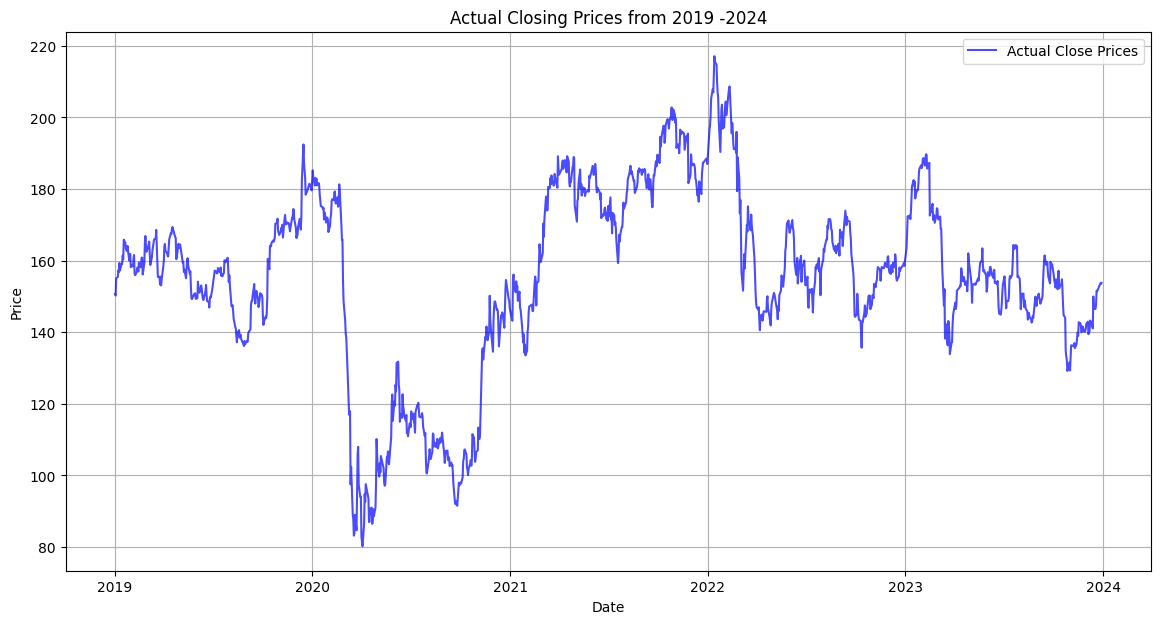

Close column head:
 Date
2019-01-02 00:00:00+00:00    150.679993
2019-01-03 00:00:00+00:00    150.259995
2019-01-04 00:00:00+00:00    155.100006
2019-01-07 00:00:00+00:00    155.419998
2019-01-08 00:00:00+00:00    157.320007
Name: (Close, BARC.L), dtype: float64
Statistics for Close column:
 count    1260.000000
mean      155.556405
std        25.624104
min        80.239998
25%       145.000000
50%       156.989998
75%       172.344997
max       217.100006
Name: (Close, BARC.L), dtype: float64


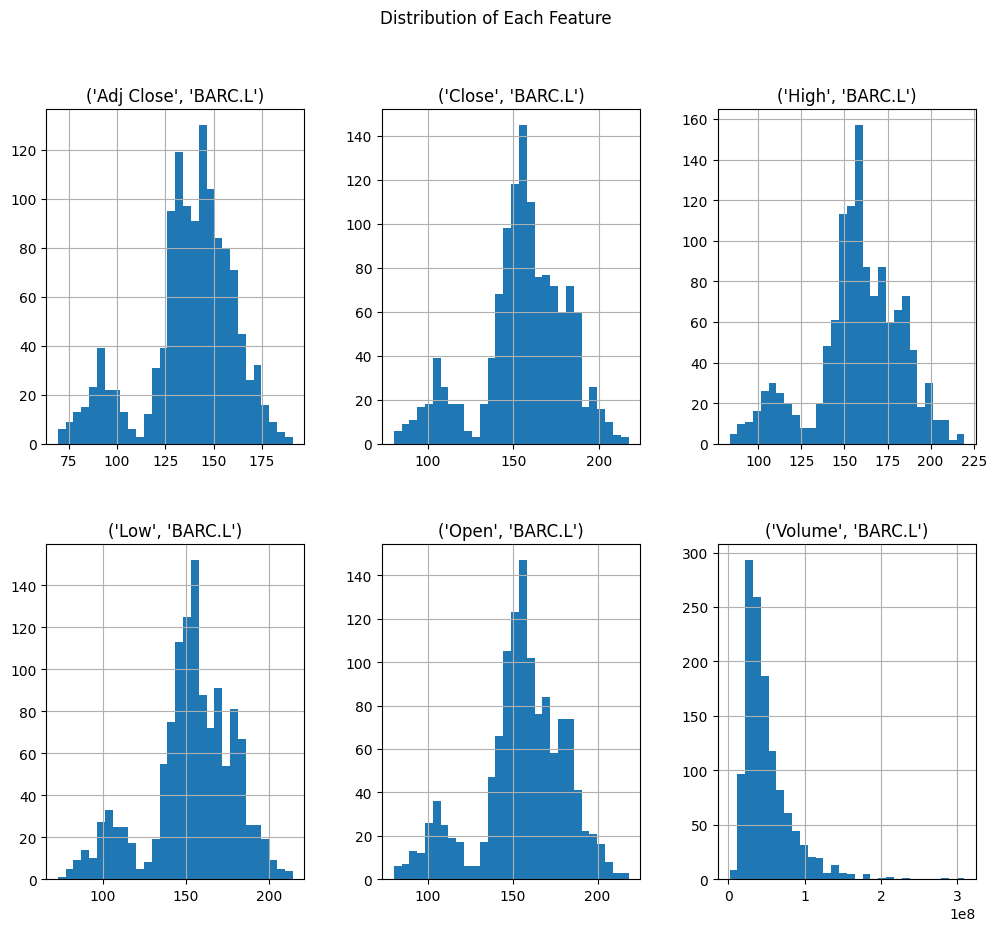

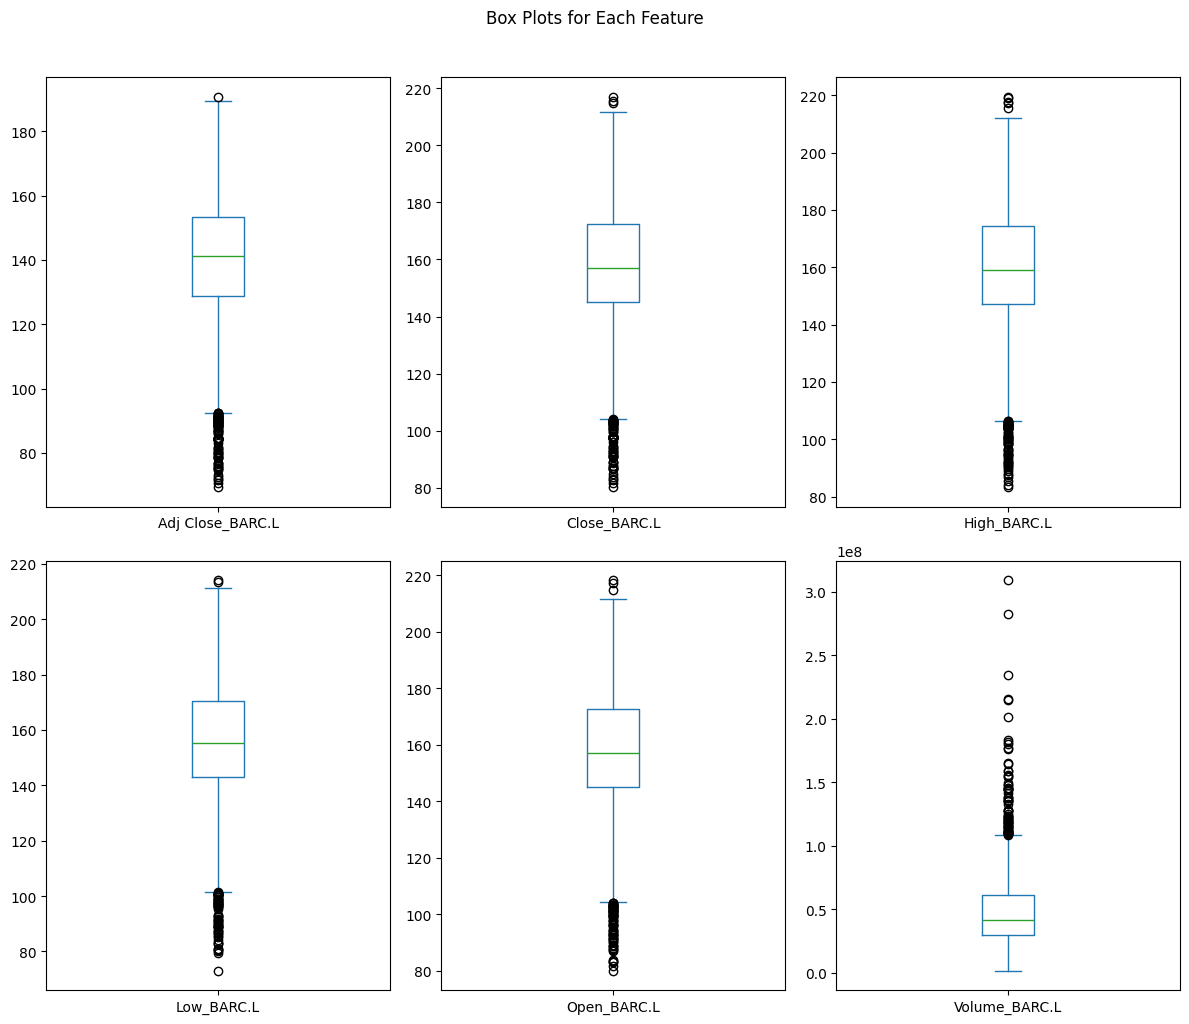

In [ ]:
eda_analysis(df,ticker)

**Fearue Engineering**

Feature engineering completed.


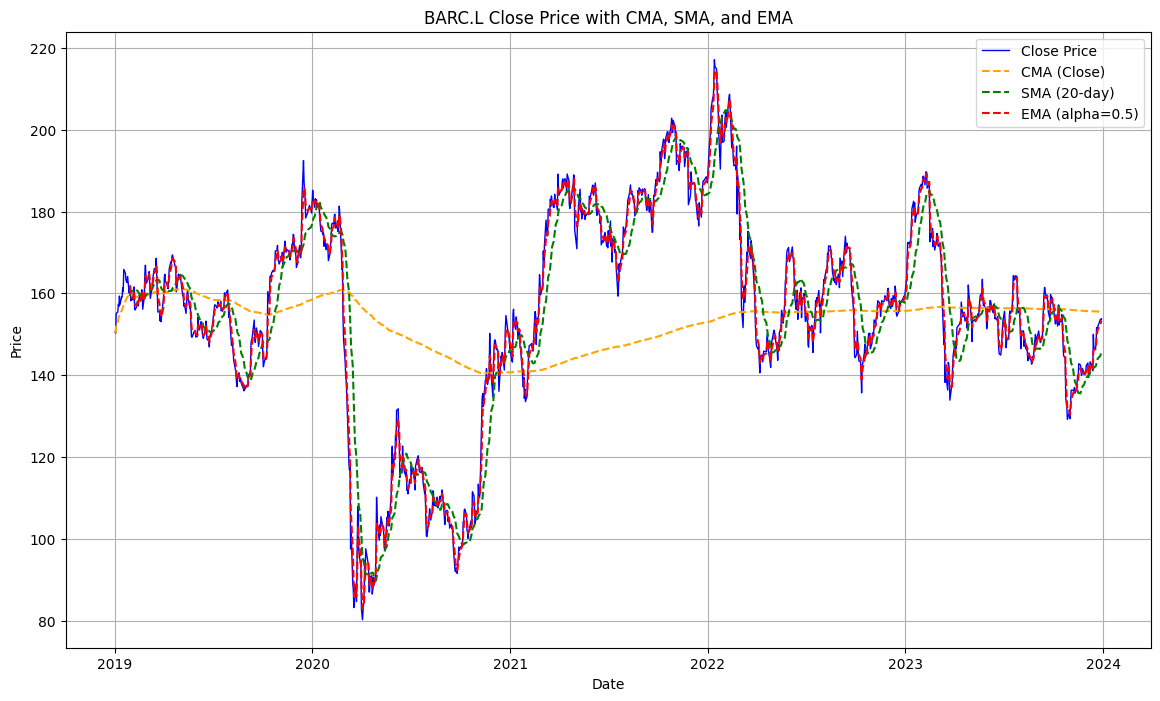

In [ ]:
feature_engineering(data,ticker)

Random forest regressor

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
<ipython-input-64-ada04cab2a6d>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=12, freq='M')


Model Performance Metrics
------------------------------
Mean Squared Error (MSE):       0.1457
Root Mean Squared Error (RMSE): 0.3817
Mean Absolute Error (MAE):      0.1235
------------------------------


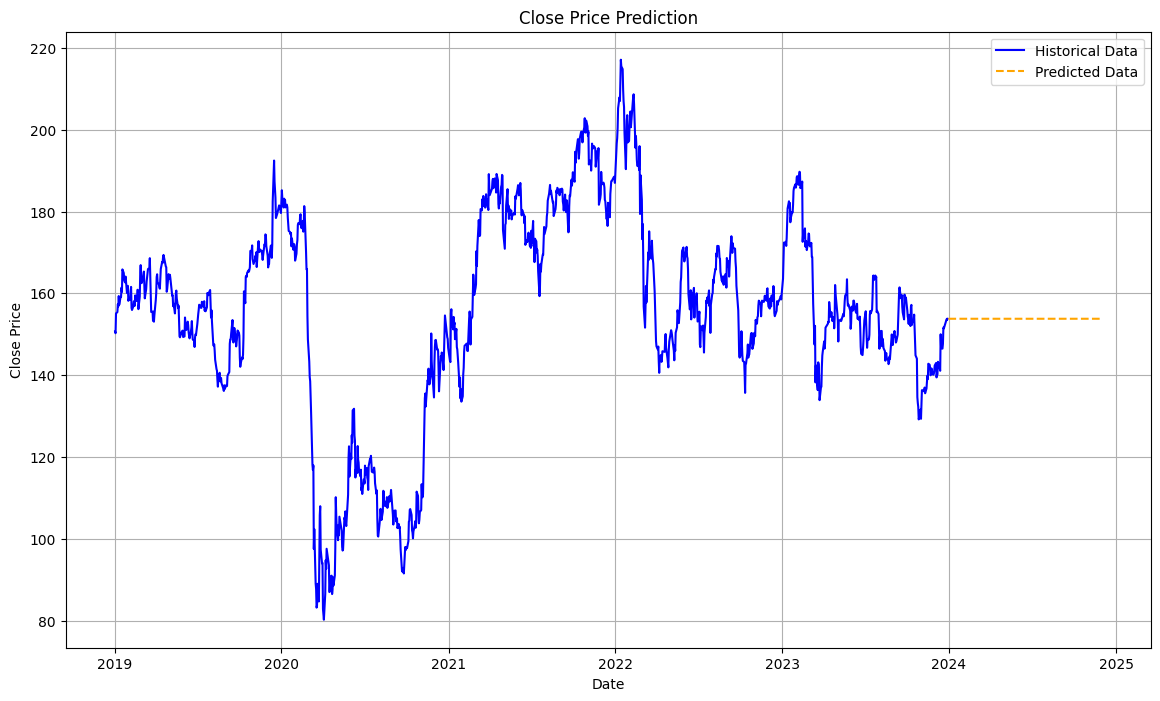

In [ ]:
X = df[['Open', 'High', 'Low', 'Close', 'Volume']]  # Example features
y = df['Close']  # Target: Stock's closing price
randomforestreg(df, X, y, target_col='Close', n_estimators=100)




random forest classifer

Model Evaluation Metrics:
Accuracy: 0.56
F1 Score: 0.54
Precision: 0.55
Recall: 0.53


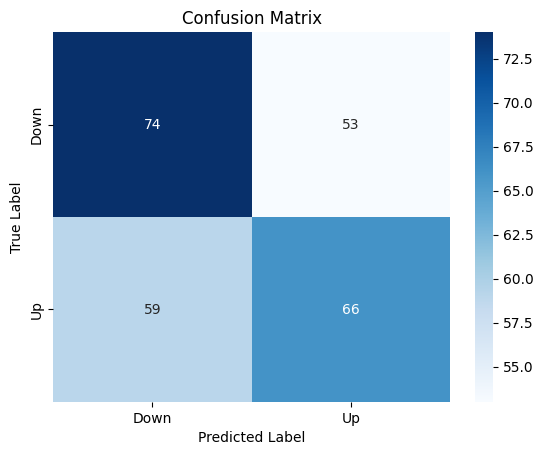

The stock price is predicted to go DOWN.


In [ ]:
X_columns = ['CMA_Close', 'SMA_Close', 'EMA_Close']
random_forest_classifier(df, X_columns, ticker)

lstm

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0923
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0110
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0072
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0063
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 0.0065
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0055
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0058
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0059
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0059
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0053
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0050
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0061
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0052
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0047
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0048
Epoch 16/50
3

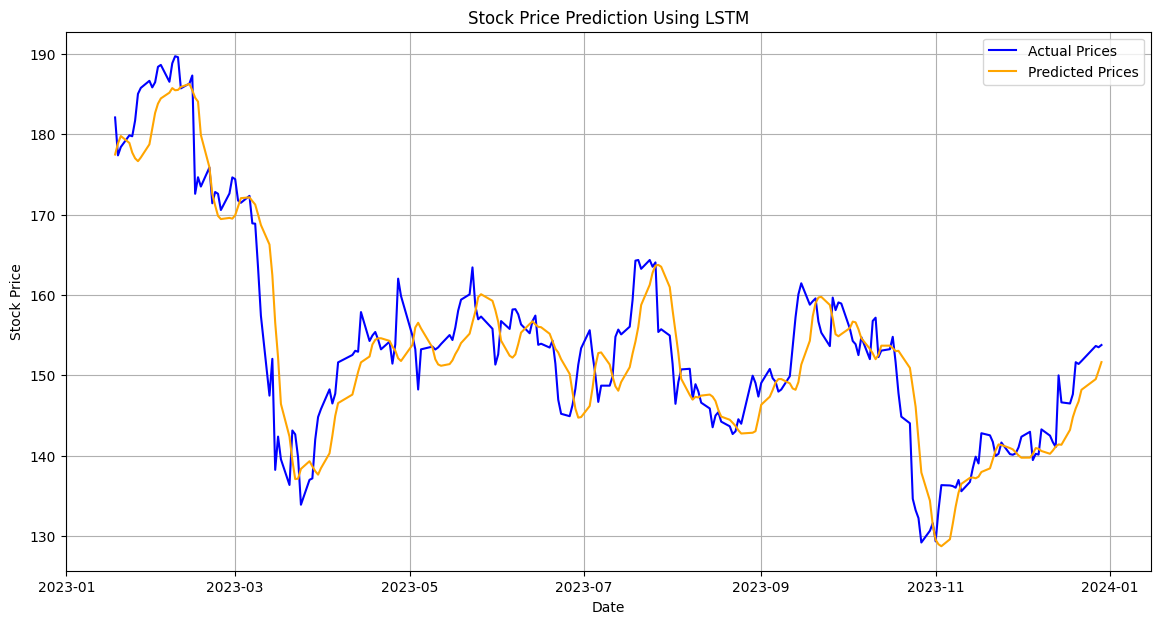

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

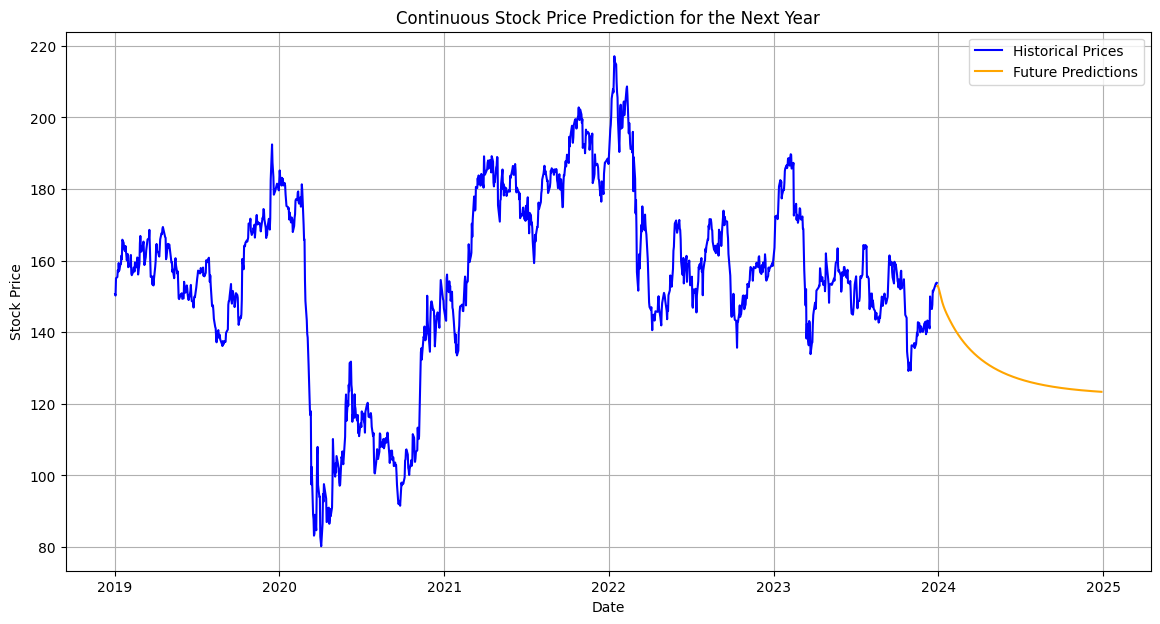

In [ ]:

X_columns = ['CMA_Close', 'SMA_Close', 'EMA_Close']  # put actual  column names of teh dataset
y_column = 'Close'
lstm(df, X_columns, y_column, epochs=50, batch_size=32, optim='adam', los='mean_squared_error')


# **Lloyds  LLOY.L**

In [ ]:
# Fetching data for Lloyds  (LLOY.L)
ticker = "LLOY.L"
data = yf.download(ticker, start="2019-01-01", end="2024-01-01")

# fixing column names by removing the ticker
df=data
# Date index in datetime formatfor graph
df.index = pd.to_datetime(df.index)
df.head()





[*********************100%***********************]  1 of 1 completed


Price                      Adj Close      Close       High        Low  \
Ticker                        LLOY.L     LLOY.L     LLOY.L     LLOY.L   
Date                                                                    
2019-01-02 00:00:00+00:00  40.189117  51.000000  51.369999  50.169998   
2019-01-03 00:00:00+00:00  40.346718  51.200001  51.680000  50.590000   
2019-01-04 00:00:00+00:00  41.607555  52.799999  52.990002  51.680000   
2019-01-07 00:00:00+00:00  42.040958  53.349998  53.650002  53.099998   
2019-01-08 00:00:00+00:00  42.316772  53.700001  54.220001  53.470001   

Price                           Open     Volume  
Ticker                        LLOY.L     LLOY.L  
Date                                             
2019-01-02 00:00:00+00:00  50.660000  142576767  
2019-01-03 00:00:00+00:00  50.930000  146329323  
2019-01-04 00:00:00+00:00  52.020000  133867623  
2019-01-07 00:00:00+00:00  53.470001  246624166  
2019-01-08 00:00:00+00:00  53.599998  124666165

In [ ]:
print("-" * 60)
print("info")
print("-" * 60)
print(df.info())
print("-" * 60)
print("Describe")
print("-" * 60)
print(df.describe())
print("-" * 60)
print("isnull")
print("-" * 60)
print(df.isnull().sum())



------------------------------------------------------------
info
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2019-01-02 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (Adj Close, LLOY.L)  1259 non-null   float64
 1   (Close, LLOY.L)      1259 non-null   float64
 2   (High, LLOY.L)       1259 non-null   float64
 3   (Low, LLOY.L)        1259 non-null   float64
 4   (Open, LLOY.L)       1259 non-null   float64
 5   (Volume, LLOY.L)     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB
None
------------------------------------------------------------
Describe
------------------------------------------------------------
Price     Adj Close        Close         High          Low         Open  \
Ticker       LLOY.L       LLOY.L       LLOY.L       LLOY.

**EDA**


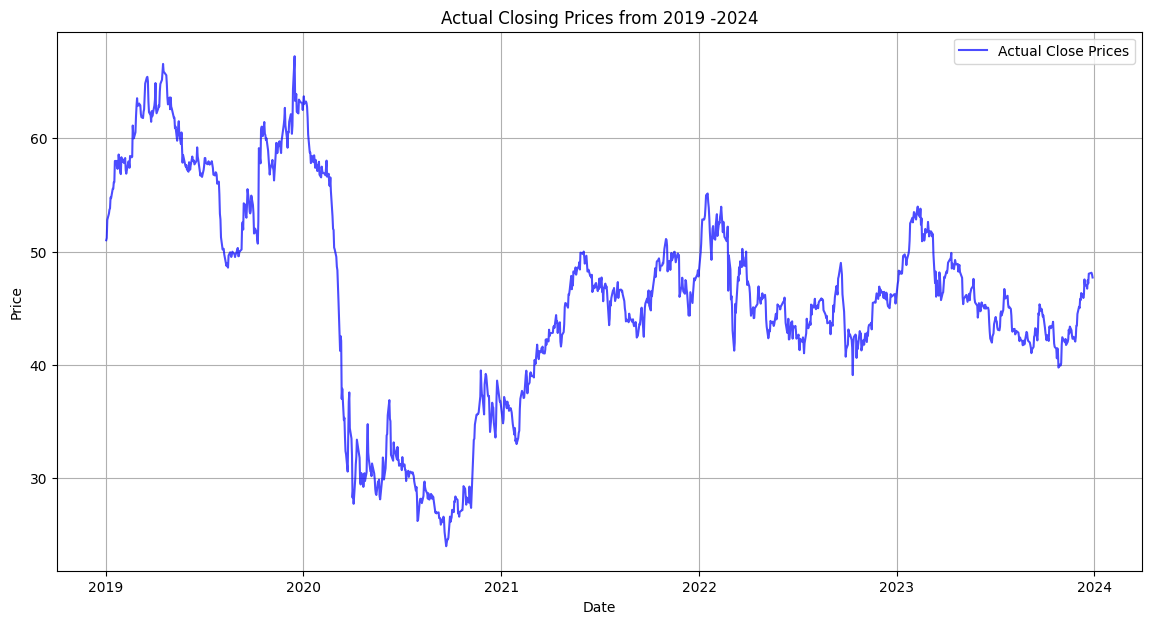

Close column head:
 Date
2019-01-02 00:00:00+00:00    51.000000
2019-01-03 00:00:00+00:00    51.200001
2019-01-04 00:00:00+00:00    52.799999
2019-01-07 00:00:00+00:00    53.349998
2019-01-08 00:00:00+00:00    53.700001
Name: (Close, LLOY.L), dtype: float64
Statistics for Close column:
 count    1259.000000
mean       45.972543
std         9.265835
min        23.980000
25%        42.075001
50%        45.840000
75%        51.420000
max        67.250000
Name: (Close, LLOY.L), dtype: float64


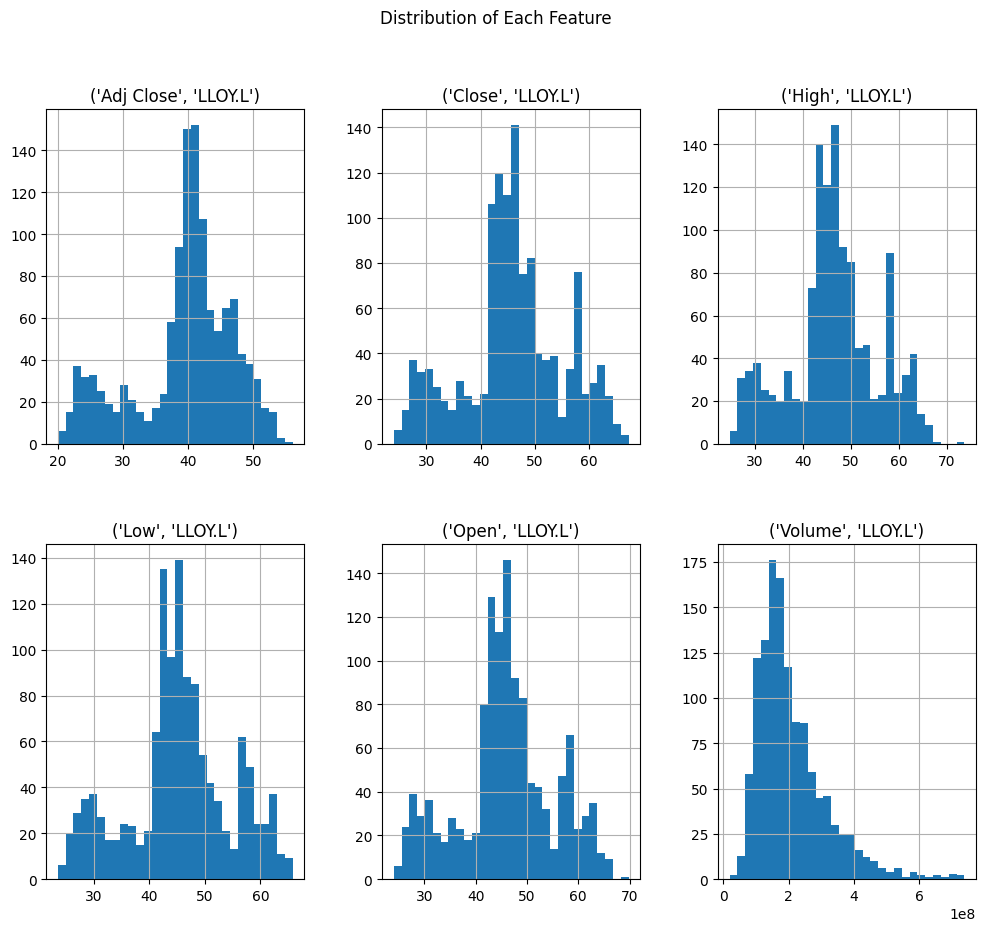

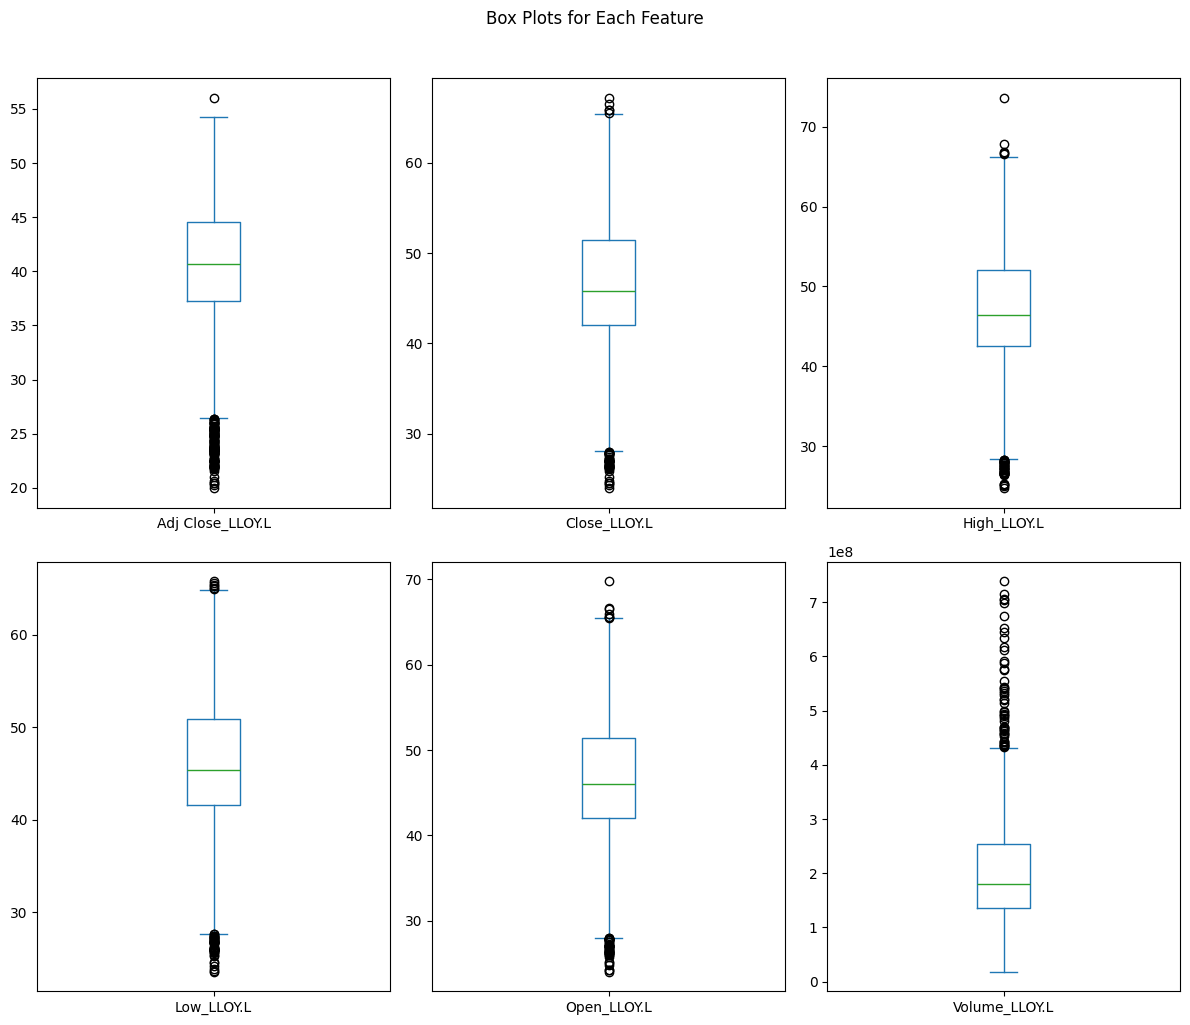

In [ ]:
eda_analysis(df,ticker)

**Fearue Engineering**

Feature engineering completed.


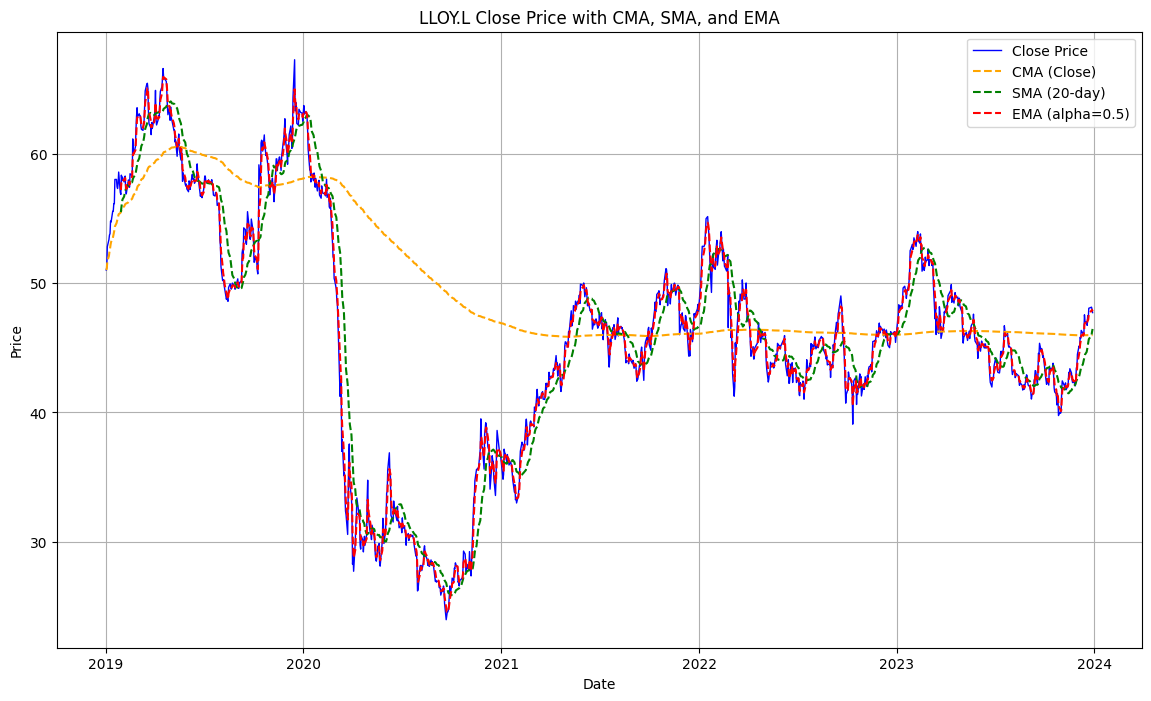

In [ ]:
feature_engineering(data,ticker)

Random forest regressor

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
<ipython-input-64-ada04cab2a6d>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=12, freq='M')


Model Performance Metrics
------------------------------
Mean Squared Error (MSE):       0.0065
Root Mean Squared Error (RMSE): 0.0804
Mean Absolute Error (MAE):      0.0354
------------------------------


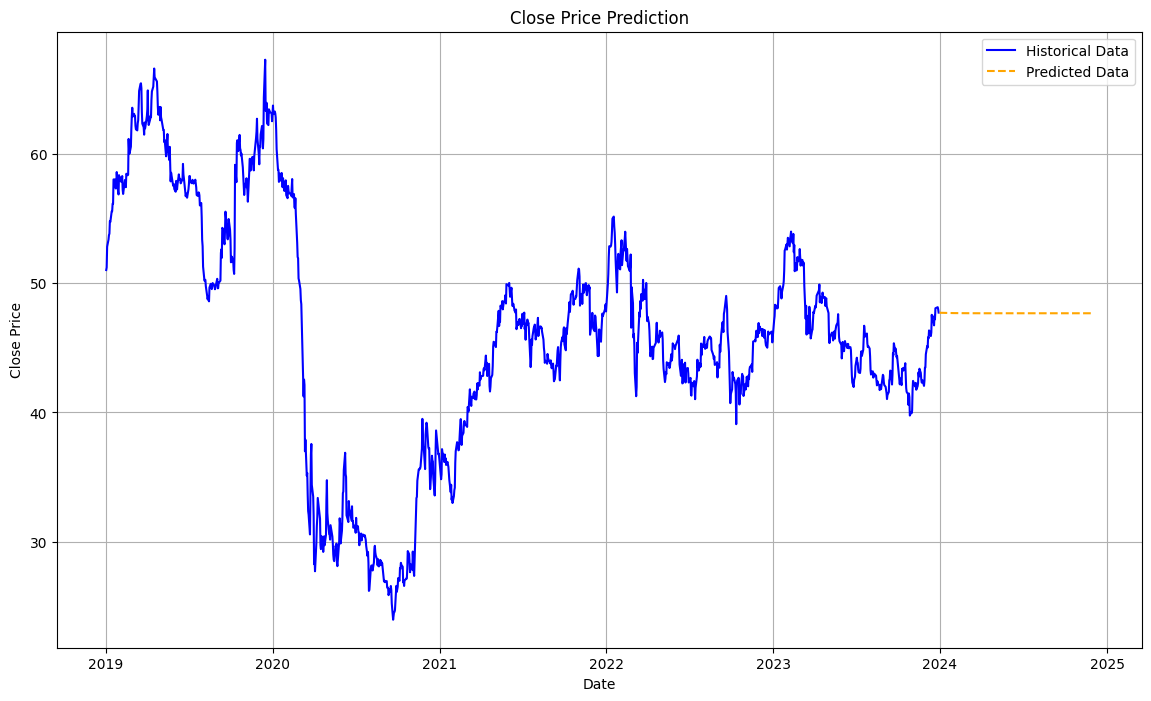

In [ ]:
X = df[['Open', 'High', 'Low', 'Close', 'Volume']]  # Example features
y = df['Close']  # Target: Stock's closing price
randomforestreg(df, X, y, target_col='Close', n_estimators=100)




random forest classifer

Model Evaluation Metrics:
Accuracy: 0.54
F1 Score: 0.51
Precision: 0.50
Recall: 0.53


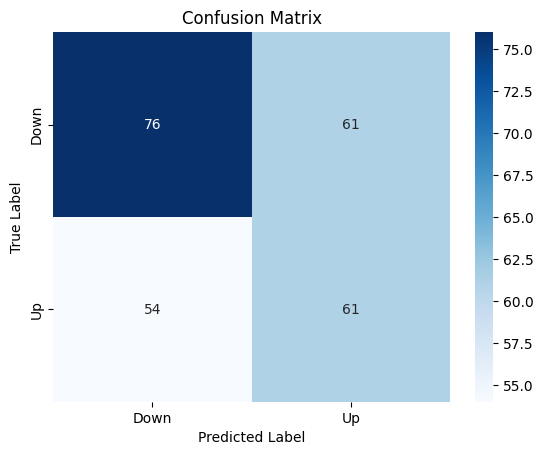

The stock price is predicted to go DOWN.


In [ ]:
X_columns = ['CMA_Close', 'SMA_Close', 'EMA_Close']
random_forest_classifier(df, X_columns, ticker)

lstm

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.1157
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0086
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0067
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0057
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0054
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0048
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0045
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0047
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0047
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0048
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0041
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0039
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0037
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0040
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0036
Epoc

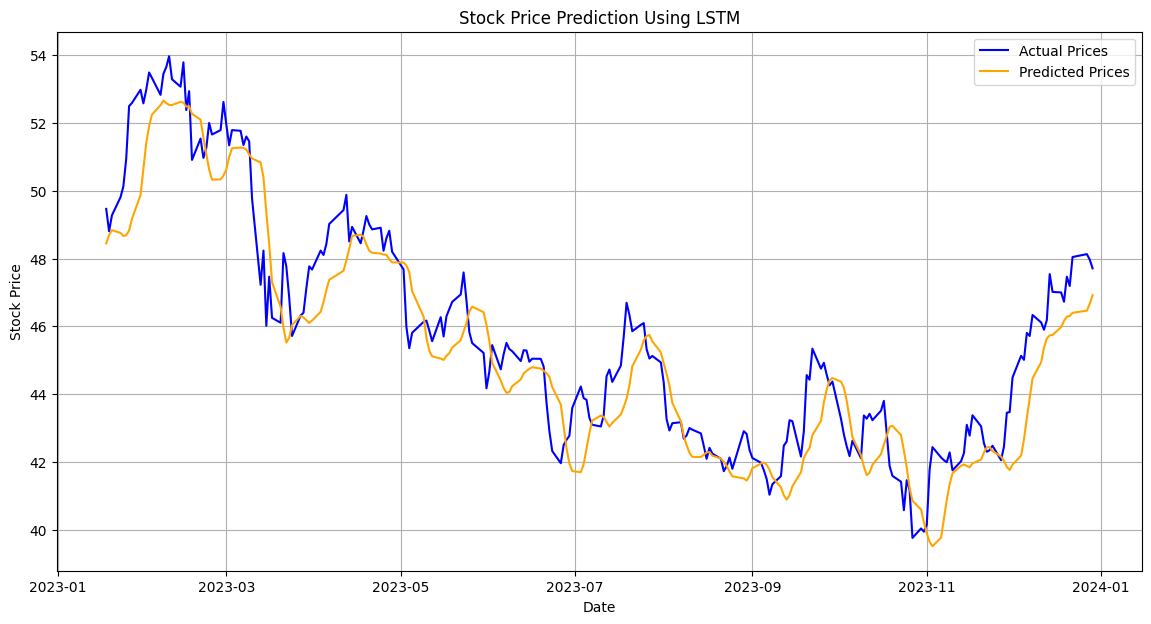

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

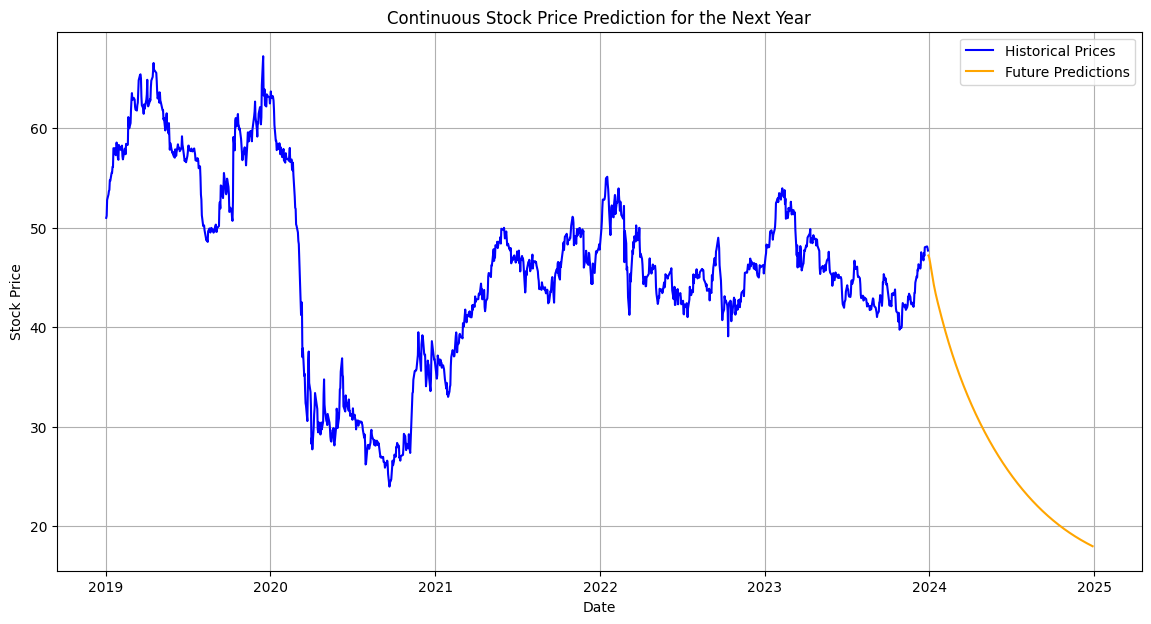

In [ ]:

X_columns = ['CMA_Close', 'SMA_Close', 'EMA_Close']  # put actual  column names of teh dataset
y_column = 'Close'
lstm(df, X_columns, y_column, epochs=50, batch_size=32, optim='adam', los='mean_squared_error')


**Extra code for better isight for data or preprocessing or model**

In [ ]:
# Calculating the number of years
start_year = df.index[0].year
end_year = df.index[-1].year
years_of_data = end_year - start_year + 1

print(f"Years of data: {years_of_data}")


In [ ]:
# Fetching data for Standard Chartered (STAN.L)
ticker = "STAN.L"
stock = yf.Ticker(ticker)

#Stock metadata
metadata = stock.info
metadata


{'address1': '1 Basinghall Avenue',
 'city': 'London',
 'zip': 'EC2V 5DD',
 'country': 'United Kingdom',
 'phone': '44 20 7885 8888',
 'fax': '44 20 7885 9999',
 'website': 'https://www.sc.com',
 'industry': 'Banks - Diversified',
 'industryKey': 'banks-diversified',
 'industryDisp': 'Banks - Diversified',
 'sector': 'Financial Services',
 'sectorKey': 'financial-services',
 'sectorDisp': 'Financial Services',
 'longBusinessSummary': 'Standard Chartered PLC, together with its subsidiaries, provides various banking products and services in Asia, Africa, the Middle East, Europe, and the Americas. The company operates in three segments: Corporate, Commercial & Institutional Banking; Consumer, Private & Business Banking; and Ventures. It offers retail products, such as deposits, mortgages, credit cards, and personal loans; wealth management products and services that include investments, portfolio management, insurance, and wealth advice; and transaction banking services, such as cash mana

In [ ]:
# Fetching data for Standard Chartered (STAN.L)
ticker = "STAN.L"
df = yf.download(ticker, start="2019-01-01", end="2024-01-01")

# Ensure 'Date' is set as index in datetime format
df.index = pd.to_datetime(df.index)


[*********************100%***********************]  1 of 1 completed


In [ ]:
from datasets import load_dataset

dataset = load_dataset("tanzuhuggingface/creditcardfraudtraining", split="train")
df = dataset.to_pandas()
print(df.head())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/182 [00:00<?, ?B/s]

credit_card_resampled.csv:   0%|          | 0.00/163M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2085138 [00:00<?, ? examples/s]

   id   index  time_elapsed        cc_num     amt      lat      long  is_fraud
0   0  347210             1  4.158950e+15    3.34  40.4308  -79.9205         0
1   1  347244             1  4.797300e+18   16.54  38.8938  -86.5246         0
2   2  347249             1  4.586810e+15   29.84  32.5486  -80.3070         0
3   3  347278             1  4.956830e+18  101.56  40.6747  -74.2239         0
4   4  347293             2  4.561550e+12    3.59  34.9889 -106.0610         0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2085138 entries, 0 to 2085137
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   index         int64  
 2   time_elapsed  int64  
 3   cc_num        float64
 4   amt           float64
 5   lat           float64
 6   long          float64
 7   is_fraud      int64  
dtypes: float64(4), int64(4)
memory usage: 127.3 MB


In [ ]:
df

id    index  time_elapsed        cc_num          amt        lat  \
0              0   347210             1  4.158950e+15     3.340000  40.430800   
1              1   347244             1  4.797300e+18    16.540000  38.893800   
2              2   347249             1  4.586810e+15    29.840000  32.548600   
3              3   347278             1  4.956830e+18   101.560000  40.674700   
4              4   347293             2  4.561550e+12     3.590000  34.988900   
...          ...      ...           ...           ...          ...        ...   
2085133  2085133   621655             4 -2.124232e+18   153.984941  38.734121   
2085134  2085134   198665            13  1.623557e+18   897.472037  31.135096   
2085135  2085135  -115788            11 -8.426380e+17  1301.453019  47.524165   
2085136  2085136  1191690             9  2.692801e+18   311.180351  47.411219   
2085137  2085137   421516             7  3.480781e+17   976.256406  47.621387   

               long  is_fraud  
0        -79.920500         0  
1        -86.524600         0  
2        -80.307000         0  
3        -74.223900         0  
4       -106.061000         0  
...             ...       ...  
2085133 -105.612185         1  
2085134  -76.789361         1  
2085135  -31.288224         1  
2085136  -50.518979         1  
2085137  -90.382931         1  

[2085138 rows x 8 columns]

In [ ]:
df.describe()

id         index  time_elapsed        cc_num           amt  \
count  2.085138e+06  2.085138e+06  2.085138e+06  2.085138e+06  2.085138e+06   
mean   1.042568e+06  5.049692e+05  1.169697e+00  3.965088e+17  2.992306e+02   
std    6.019276e+05  4.089742e+05  7.291183e+00  1.637756e+18  4.955343e+02   
min    0.000000e+00 -1.612912e+06 -3.000000e+01 -6.986079e+18 -2.159578e+03   
25%    5.212842e+05  2.117852e+05  0.000000e+00  6.304420e+11  1.501000e+01   
50%    1.042568e+06  5.054810e+05  0.000000e+00  3.543300e+15  8.474000e+01   
75%    1.563853e+06  8.031388e+05  2.000000e+00  5.330299e+17  5.406551e+02   
max    2.085137e+06  2.794497e+06  8.300000e+01  1.122925e+19  2.894890e+04   

                lat          long   is_fraud  
count  2.085138e+06  2.085138e+06  2085138.0  
mean   3.858014e+01 -9.004107e+01        0.5  
std    6.704931e+00  1.827680e+01        0.5  
min    1.511058e+00 -2.269371e+02        0.0  
25%    3.408775e+01 -9.925484e+01        0.0  
50%    3.911268e+01 -8.799734e+01        0.5  
75%    4.272800e+01 -7.844002e+01        1.0  
max    9.152811e+01  1.470988e-01        1.0

In [ ]:
pip install pandas requests datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00


Accuracy: 0.9955
F1 Score: 0.9955
Recall: 0.9955


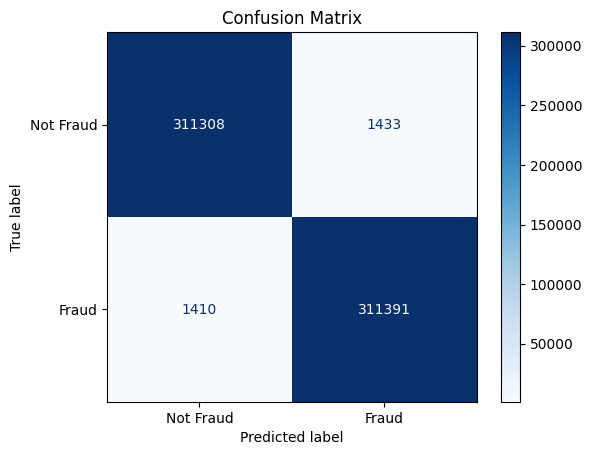

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming 'df' is already loaded with your data

# Select features and target
X = df[['index', 'time_elapsed', 'cc_num', 'amt', 'lat', 'long']]
y = df['is_fraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
!pip install openml


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.4 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=a7fb67e73cae406eb3d3239143161a633c6a39264196c1194c54af6deaf7fc09
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff


In [ ]:
import openml
import pandas as pd

# Load dataset from OpenML
dataset = openml.datasets.get_dataset(1597)
df, *_ = dataset.get_data(target=dataset.default_target_attribute)

# Display the DataFrame
print(df.head())  # Prints the first 5 rows of the DataFrame
print("\nDataFrame Shape:", df.shape)  # Prints the shape of the DataFrame
df

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V20       V21       V22       V23  \
0  0.098698  0.363787  0.090794  ...  0.251412 -0.018307  0.277838 -0.110474   
1  0.085102 -0.255425 -0.166974  ... -0.069083 -0.225775 -0.638672  0.101288   
2  0.247676 -1.514654  0.207643  ...  0.524980  0.247998  0.771679  0.909412   
3  0.377436 -1.387024 -0.054952  ... -0.208038 -0.108300  0.005274 -0.190321   
4 -0.270533  0.817739  0.753074  ...  0.408542 -0.009431  0.798278 -0.137458   

        V24       V25       V26       V27       V28  Amount  
0  0.0

V1         V2        V3        V4        V5        V6  \
0       -1.359807  -0.072781  2.536347  1.378155 -0.338321  0.462388   
1        1.191857   0.266151  0.166480  0.448154  0.060018 -0.082361   
2       -1.358354  -1.340163  1.773209  0.379780 -0.503198  1.800499   
3       -0.966272  -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4       -1.158233   0.877737  1.548718  0.403034 -0.407193  0.095921   
...           ...        ...       ...       ...       ...       ...   
284802 -11.881118  10.071785 -9.834783 -2.066656 -5.364473 -2.606837   
284803  -0.732789  -0.055080  2.035030 -0.738589  0.868229  1.058415   
284804   1.919565  -0.301254 -3.249640 -0.557828  2.630515  3.031260   
284805  -0.240440   0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  -0.533413  -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9       V10  ...       V20       V21  \
0       0.239599  0.098698  0.363787  0.090794  ...  0.251412 -0.018307   
1      -0.078803  0.085102 -0.255425 -0.166974  ... -0.069083 -0.225775   
2       0.791461  0.247676 -1.514654  0.207643  ...  0.524980  0.247998   
3       0.237609  0.377436 -1.387024 -0.054952  ... -0.208038 -0.108300   
4       0.592941 -0.270533  0.817739  0.753074  ...  0.408542 -0.009431   
...          ...       ...       ...       ...  ...       ...       ...   
284802 -4.918215  7.305334  1.914428  4.356170  ...  1.475829  0.213454   
284803  0.024330  0.294869  0.584800 -0.975926  ...  0.059616  0.214205   
284804 -0.296827  0.708417  0.432454 -0.484782  ...  0.001396  0.232045   
284805 -0.686180  0.679145  0.392087 -0.399126  ...  0.127434  0.265245   
284806  1.577006 -0.414650  0.486180 -0.915427  ...  0.382948  0.261057   

             V22       V23       V24       V25       V26       V27       V28  \
0       0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1      -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724   
2       0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3       0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458   
4       0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   
...          ...       ...       ...       ...       ...       ...       ...   
284802  0.111864  1.014480 -0.509348  1.436807  0.250034  0.943651  0.823731   
284803  0.924384  0.012463 -1.016226 -0.606624 -0.395255  0.068472 -0.053527   
284804  0.578229 -0.037501  0.640134  0.265745 -0.087371  0.004455 -0.026561   
284805  0.800049 -0.163298  0.123205 -0.569159  0.546668  0.108821  0.104533   
284806  0.643078  0.376777  0.008797 -0.473649 -0.818267 -0.002415  0.013649   

        Amount  
0       149.62  
1         2.69  
2       378.66  
3       123.50  
4        69.99  
...        ...  
284802    0.77  
284803   24.79  
284804   67.88  
284805   10.00  
284806  217.00  

[284807 rows x 29 columns]

In [ ]:
df.describe()

V1            V2            V3            V4            V5  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15  9.604066e-16   
std    1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00  1.380247e+00   
min   -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00 -1.137433e+02   
25%   -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01 -6.915971e-01   
50%    1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02 -5.433583e-02   
75%    1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01  6.119264e-01   
max    2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01  3.480167e+01   

                 V6            V7            V8            V9           V10  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.487313e-15 -5.556467e-16  1.205498e-16 -2.406306e-15  2.238853e-15   
std    1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00  1.088850e+00   
min   -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01 -2.458826e+01   
25%   -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01 -5.354257e-01   
50%   -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02 -9.291738e-02   
75%    3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01  4.539234e-01   
max    7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01  2.374514e+01   

       ...           V20           V21           V22           V23  \
count  ...  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   ...  6.407202e-16  1.656562e-16 -3.568593e-16  2.610582e-16   
std    ...  7.709250e-01  7.345240e-01  7.257016e-01  6.244603e-01   
min    ... -5.449772e+01 -3.483038e+01 -1.093314e+01 -4.480774e+01   
25%    ... -2.117214e-01 -2.283949e-01 -5.423504e-01 -1.618463e-01   
50%    ... -6.248109e-02 -2.945017e-02  6.781943e-03 -1.119293e-02   
75%    ...  1.330408e-01  1.863772e-01  5.285536e-01  1.476421e-01   
max    ...  3.942090e+01  2.720284e+01  1.050309e+01  2.252841e+01   

                V24           V25           V26           V27           V28  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   4.473066e-15  5.213180e-16  1.683537e-15 -3.659966e-16 -1.223710e-16   
std    6.056471e-01  5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01   
min   -2.836627e+00 -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01   
25%   -3.545861e-01 -3.171451e-01 -3.269839e-01 -7.083953e-02 -5.295979e-02   
50%    4.097606e-02  1.659350e-02 -5.213911e-02  1.342146e-03  1.124383e-02   
75%    4.395266e-01  3.507156e-01  2.409522e-01  9.104512e-02  7.827995e-02   
max    4.584549e+00  7.519589e+00  3.517346e+00  3.161220e+01  3.384781e+01   

              Amount  
count  284807.000000  
mean       88.349619  
std       250.120109  
min         0.000000  
25%         5.600000  
50%        22.000000  
75%        77.165000  
max     25691.160000  

[8 rows x 29 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 29 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

In [ ]:
import openml
import pandas as pd

# Load dataset from OpenML
dataset = openml.datasets.get_dataset(1597)
df, *_ = dataset.get_data(target=dataset.default_target_attribute)

# Display the 'Class' column, which indicates fraud or not
print(df['Class'].value_counts())  # Shows count of fraud vs. non-fraud transactions
print(df['Class'].head())  # Prints the first few entries of the target column


KeyError: 'Class'

In [ ]:
# Display all column names to check the exact label for the target column
print("Column names:", df.columns)

# If the target column is different, update the code to print it accordingly
# Example if the target column is labeled differently, like 'is_fraud'
# print(df['is_fraud'].value_counts())


Column names: Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')
